In [1]:
# Import

import numpy
import pandas
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.statistics import mean, variance
from harmonica.statistics import weighted_mean, weighted_variance
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

# Example-01: Model setup

In [3]:
# Model configuration is stored in a yaml format (python dictionary) with data for each location (a point of interest)
# Model can be specified by CS twiss parameters (and corresponding errors) at locations and phase advances between locations (uncoupled model)
# Or model can be specified by normalization matrices (and corresponding errors) at the locations and phase advances between locations (coupled model)

In [4]:
# Uncoupled model is specified by CS twiss parameters and phase advances (from start to location) has the following format:

# DEFAULT CONFIGURATION FILE (UNCOUPLED MODEL FROM TWISS)
# NOTE, HEAD AND TAIL VIRTUAL LOCATIONS SHOULD ALWAYS PRESENT

# LOCATION RECORD
# <NAME>: {TYPE:<TYPE>, FLAG:<FLAG>, JOIN:<JOIN>, RISE:<RISE>, TIME:<TIME>, AX:<AX>, BX:<BX>, FX:<FX>, AY:<AY>, BX:<BY>, FY:<FY>, SIGMA_AX:<SIGMA_AX>, SIGMA_BX:<SIGMA_BX>, SIGMA_FX:<SIGMA_FX>, SIGMA_AY:<SIGMA_AY>, SIGMA_BY:<SIGMA_BY>, SIGMA_FY:<SIGMA_FY>}
# <NAME>:
#   LOCATION NAME
#   HEAD & TAIL ARE SPECIAL VIRTUAL LOCATIONS
# <TYPE>:
#   LOCATION TYPE (VIRTUAL OR MONITOR)
#   MONITOR TYPE SHOULD BE USED FOR LOCATIONS WHERE TBT DATA IS AVALIBLE
#   OTHER LOCATIONS WHERE TBT DATA IS NOT AVALIBLE DIRECTRY SHOULD BE DEFINED AS VIRTUAL
#   FREQUENCY AND OTHER PARAMETERS INFERRED FROM TBT DATA ARE NOT COMPUTED FOR VIRTUAL LOCATIONS
#   IF BPM IS OFF, TYPE IS CHANGED TO VIRTUAL
#   IF BPM IS FLAGGED (E.G. ANOMALY OR SHYNCHRONIZATION ERROR), TYPE IS CHANGED TO VIRTUAL
# <FLAG>:
#   FLAG TO COMPUTE OPTICS (0 OR 1)
# <JOIN>:
#   FLAG TO USE IN MIXED DATA COMPUTAION
# <RISE>:
#   LOCATION RISE
#   STARTING TURN FOR MONITOR LOCATION
# <TIME>:
#   PHYSICAL LOCATION
#   NOTE, ORDERING IS CHECKED BY PHYSICAL LOCATION
# <AX>, <BX>, <FX>, <AY>, <BY>, <FY>
#   UNCOUPLED TWISS PARAMETERS
#   NOTE, PHASE ADVANCE IS DEFIEND FROM HEAD TO LOCATION
# <SIGMA_AX>, <SIGMA_BX>, <SIGMA_FX>, <SIGMA_AY>, <SIGMA_BY>, <SIGMA_FY>
#   MODEL TWISS ERROR AT THE LOCATION AND PHASE ADVANCE ERROR FROM GIVEN LOCATION TO THE NEXT ONE

# HEAD            :  {TYPE: VIRTUAL         , FLAG:  0, JOIN:  0, RISE: -1, TIME:   0.0000000000000000E+00, AX:  -6.7832172200684859E-01, BX:   7.4674609407469461E+00, FX:   0.0000000000000000E+00, AY:   6.5444027545037686E-01, BY:   1.5854388146461160E+01, FY:   0.0000000000000000E+00, SIGMA_AX:   0.0000000000000000E+00, SIGMA_BX:   0.0000000000000000E+00, SIGMA_FX:   0.0000000000000000E+00, SIGMA_AY:   0.0000000000000000E+00, SIGMA_BY:   0.0000000000000000E+00, SIGMA_FY:   0.0000000000000000E+00}
# STP2            :  {TYPE: MONITOR         , FLAG:  1, JOIN:  1, RISE:  8, TIME:   0.0000000000000000E+00, AX:  -6.7832172200684859E-01, BX:   7.4674609407469461E+00, FX:   0.0000000000000000E+00, AY:   6.5444027545037686E-01, BY:   1.5854388146461160E+01, FY:   0.0000000000000000E+00, SIGMA_AX:   0.0000000000000000E+00, SIGMA_BX:   0.0000000000000000E+00, SIGMA_FX:   0.0000000000000000E+00, SIGMA_AY:   0.0000000000000000E+00, SIGMA_BY:   0.0000000000000000E+00, SIGMA_FY:   0.0000000000000000E+00}
# ...
# TAIL            :  {TYPE: VIRTUAL         , FLAG:  0, JOIN:  0, RISE: -1, TIME:   3.6607501559999957E+02, AX:  -6.7832172200673979E-01, BX:   7.4674609407466637E+00, FX:   5.3638818455096327E+01, AY:   6.5444027545039363E-01, BY:   1.5854388146461030E+01, FY:   4.7606279051923941E+01, SIGMA_AX:   0.0000000000000000E+00, SIGMA_BX:   0.0000000000000000E+00, SIGMA_FX:   0.0000000000000000E+00, SIGMA_AY:   0.0000000000000000E+00, SIGMA_BY:   0.0000000000000000E+00, SIGMA_FY:   0.0000000000000000E+00}

In [5]:
# Coupled model specified by normalization matrices and phase advances (from start to location) has the following format

# DEFAULT CONFIGURATION FILE (COUPLED MODEL FROM NORMAL)
# NOTE, HEAD AND TAIL VIRTUAL LOCATIONS SHOULD ALWAYS PRESENT

# LOCATION RECORD
# <NAME>: {TYPE:<TYPE>, FLAG:<FLAG>, JOIN:<JOIN>, RISE:<RISE>, TIME:<TIME>, ..., NIJ:<NIJ>, ..., FX:<FX>, FY:<FY>, ..., SIGMA_NIJ:<SIGMA_NIJ>, ... , SIGMA_FX:<SIGMA_FX>, SIGMA_FY:<SIGMA_FY>}
# <NAME>:
#   LOCATION NAME
#   HEAD & TAIL ARE SPECIAL VIRTUAL LOCATIONS
# <TYPE>:
#   LOCATION TYPE (VIRTUAL OR MONITOR)
#   MONITOR TYPE SHOULD BE USED FOR LOCATIONS WHERE TBT DATA IS AVALIBLE
#   OTHER LOCATIONS WHERE TBT DATA IS NOT AVALIBLE DIRECTRY SHOULD BE DEFINED AS VIRTUAL
#   FREQUENCY AND OTHER PARAMETERS INFERRED FROM TBT DATA ARE NOT COMPUTED FOR VIRTUAL LOCATIONS
#   IF BPM IS OFF, TYPE IS CHANGED TO VIRTUAL
#   IF BPM IS FLAGGED (E.G. ANOMALY OR SHYNCHRONIZATION ERROR), TYPE IS CHANGED TO VIRTUAL
# <FLAG>:
#   FLAG TO COMPUTE OPTICS (0 OR 1)
# <JOIN>:
#   FLAG TO USE IN MIXED DATA COMPUTAION
# <RISE>:
#   LOCATION RISE
#   STARTING TURN FOR MONITOR LOCATION
# <TIME>:
#   PHYSICAL LOCATION
#   NOTE, ORDERING IS CHECKED BY PHYSICAL LOCATION
# <NIJ>:
#   NORMALIZATION MATRIX IJ ELEMENT
# <FX>, <FY>
#   PHASE ADVANCE
#   NOTE, PHASE ADVANCE IS DEFIEND FROM HEAD TO LOCATION
# <SIGMA_NIJ>
#   MODEL NORMALIZATION MATRIX IJ ELEMENT ERROR
# <SIGMA_FX>, <SIGMA_FY>
#   PHASE ADVANCE ERROR FROM GIVEN LOCATION TO THE NEXT ONE

# HEAD            :  {TYPE: VIRTUAL         , FLAG:  0, JOIN:  0, RISE: -1, TIME:   0.0000000000000000E+00, N00:   2.7326655376659064E+00, N01:   0.0000000000000000E+00, N02:   0.0000000000000000E+00, N03:   0.0000000000000000E+00, N10:   2.4822712939331223E-01, N11:   3.6594306409490018E-01, N12:   0.0000000000000000E+00, N13:   0.0000000000000000E+00, N20:   0.0000000000000000E+00, N21:   0.0000000000000000E+00, N22:   3.9817569170481910E+00, N23:   0.0000000000000000E+00, N30:   0.0000000000000000E+00, N31:   0.0000000000000000E+00, N32:  -1.6435967566185433E-01, N33:   2.5114541666730716E-01, FX:   0.0000000000000000E+00, FY:   0.0000000000000000E+00, SIGMA_N00:   0.0000000000000000E+00, SIGMA_N01:   0.0000000000000000E+00, SIGMA_N02:   0.0000000000000000E+00, SIGMA_N03:   0.0000000000000000E+00, SIGMA_N10:   0.0000000000000000E+00, SIGMA_N11:   0.0000000000000000E+00, SIGMA_N12:   0.0000000000000000E+00, SIGMA_N13:   0.0000000000000000E+00, SIGMA_N20:   0.0000000000000000E+00, SIGMA_N21:   0.0000000000000000E+00, SIGMA_N22:   0.0000000000000000E+00, SIGMA_N23:   0.0000000000000000E+00, SIGMA_N30:   0.0000000000000000E+00, SIGMA_N31:   0.0000000000000000E+00, SIGMA_N32:   0.0000000000000000E+00, SIGMA_N33:   0.0000000000000000E+00, SIGMA_FX:   0.0000000000000000E+00, SIGMA_FY:   0.0000000000000000E+00}
# STP2            :  {TYPE: MONITOR         , FLAG:  1, JOIN:  1, RISE:  8, TIME:   0.0000000000000000E+00, N00:   2.7326655376659064E+00, N01:   0.0000000000000000E+00, N02:   0.0000000000000000E+00, N03:   0.0000000000000000E+00, N10:   2.4822712939331223E-01, N11:   3.6594306409490018E-01, N12:   0.0000000000000000E+00, N13:   0.0000000000000000E+00, N20:   0.0000000000000000E+00, N21:   0.0000000000000000E+00, N22:   3.9817569170481910E+00, N23:   0.0000000000000000E+00, N30:   0.0000000000000000E+00, N31:   0.0000000000000000E+00, N32:  -1.6435967566185433E-01, N33:   2.5114541666730716E-01, FX:   0.0000000000000000E+00, FY:   0.0000000000000000E+00, SIGMA_N00:   0.0000000000000000E+00, SIGMA_N01:   0.0000000000000000E+00, SIGMA_N02:   0.0000000000000000E+00, SIGMA_N03:   0.0000000000000000E+00, SIGMA_N10:   0.0000000000000000E+00, SIGMA_N11:   0.0000000000000000E+00, SIGMA_N12:   0.0000000000000000E+00, SIGMA_N13:   0.0000000000000000E+00, SIGMA_N20:   0.0000000000000000E+00, SIGMA_N21:   0.0000000000000000E+00, SIGMA_N22:   0.0000000000000000E+00, SIGMA_N23:   0.0000000000000000E+00, SIGMA_N30:   0.0000000000000000E+00, SIGMA_N31:   0.0000000000000000E+00, SIGMA_N32:   0.0000000000000000E+00, SIGMA_N33:   0.0000000000000000E+00, SIGMA_FX:   0.0000000000000000E+00, SIGMA_FY:   0.0000000000000000E+00}
# ...
# TAIL            :  {TYPE: VIRTUAL         , FLAG:  0, JOIN:  0, RISE: -1, TIME:   3.6607501559999957E+02, N00:   2.7326655376658477E+00, N01:  -2.2204460492503131E-16, N02:   0.0000000000000000E+00, N03:   0.0000000000000000E+00, N10:   2.4822712939327973E-01, N11:   3.6594306409490629E-01, N12:   0.0000000000000000E+00, N13:   0.0000000000000000E+00, N20:   0.0000000000000000E+00, N21:   0.0000000000000000E+00, N22:   3.9817569170481679E+00, N23:  -2.2204460492503131E-16, N30:   0.0000000000000000E+00, N31:   0.0000000000000000E+00, N32:  -1.6435967566185916E-01, N33:   2.5114541666730861E-01, FX:   5.3638818455096327E+01, FY:   4.7606279051923941E+01, SIGMA_N00:   0.0000000000000000E+00, SIGMA_N01:   0.0000000000000000E+00, SIGMA_N02:   0.0000000000000000E+00, SIGMA_N03:   0.0000000000000000E+00, SIGMA_N10:   0.0000000000000000E+00, SIGMA_N11:   0.0000000000000000E+00, SIGMA_N12:   0.0000000000000000E+00, SIGMA_N13:   0.0000000000000000E+00, SIGMA_N20:   0.0000000000000000E+00, SIGMA_N21:   0.0000000000000000E+00, SIGMA_N22:   0.0000000000000000E+00, SIGMA_N23:   0.0000000000000000E+00, SIGMA_N30:   0.0000000000000000E+00, SIGMA_N31:   0.0000000000000000E+00, SIGMA_N32:   0.0000000000000000E+00, SIGMA_N33:   0.0000000000000000E+00, SIGMA_FX:   0.0000000000000000E+00, SIGMA_FY:   0.0000000000000000E+00}

In [6]:
# Set uncoupled Model instance
# All configuration is saved in data_frame attribute

model = Model(path='../config_uncoupled.yaml', model='uncoupled', dtype=dtype, device=device)
model.data_frame

,HEAD,STP2,IV4P,STP4,SRP1,SRP2,SRP3,SRP4,SRP5,SRP6,...,NRP4,NRP3,NRP2,NRP1,NTP4,IV4E,NTP2,NTP0,STP0,TAIL
TYPE,VIRTUAL,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,...,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,VIRTUAL
FLAG,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
JOIN,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
RISE,-1,8,-1,8,8,8,8,8,8,8,...,9,9,9,9,9,-1,9,9,9,-1
TIME,0.0,0.0,4.1535,6.667,10.190565,17.337624,24.484683,31.631742,38.778801,45.92586,...,314.367774,321.514833,328.661892,335.808951,339.332516,341.846016,345.999516,353.307016,358.767516,366.075016
AX,-0.678322,-0.678322,1.955065,0.382216,-0.801359,-0.720007,-0.769987,-0.788485,-0.715242,-0.788853,...,0.788485,0.769987,0.720007,0.801359,-0.382216,-1.955065,0.678322,0.187567,-0.187567,-0.678322
BX,7.467461,7.467461,14.238343,3.121346,4.735711,4.560311,4.48402,4.755363,4.490419,4.552264,...,4.755363,4.48402,4.560311,4.735711,3.121346,14.238343,7.467461,15.068229,15.068229,7.467461
FX,0.0,0.0,0.385863,0.837521,1.965122,3.064451,4.221361,5.333373,6.443944,7.601242,...,45.781099,46.893111,48.050022,49.14935,50.276951,50.72861,51.114472,52.191233,52.562058,53.638818
AY,0.65444,0.65444,-2.759872,3.092008,1.839816,1.839551,1.84704,1.847097,1.839606,1.839758,...,-1.847097,-1.84704,-1.839551,-1.839816,-3.092008,2.759872,-0.65444,0.954725,-0.954725,0.65444
BY,15.854388,15.854388,13.855747,30.432785,13.261256,13.282406,13.324616,13.302293,13.260703,13.284183,...,13.302293,13.324616,13.282406,13.261256,30.432785,13.855747,15.854388,5.466362,5.466362,15.854388


In [7]:
# Main attributes (on initialization, note, additional attributes are set by instance methods)

#     _epsilon: float
#         float epsilon
#     _head: str
#         head location name
#     _tail: str
#         tail location name
#     _virtual: str
#         virtual type
#     _monitor: str
#         monitor type
#     dtype: torch.dtype
#         torch data type
#     device: torch.device
#         torch device
#     path: str
#         path to yaml config file
#     limit: int
#         maximum range limit
#     error: bool
#         flag to compute model advance errors
#     model: str
#         model type ('uncoupled' or 'coumpled')
#     dict: dict
#         yaml file as dict
#     data_frame: pandas.DataFrame
#         yaml config file as data frame
#     size: int
#         number of locations
#     name: list
#         location names
#     kind: list
#         location kinds (expected kinds _virtual or _monitor)
#     flag: torch.Tensor
#         flags
#     join: list
#         join flags
#     rise: list
#         starting turn
#     time: torch.Tensor
#         position
#     length: torch.Tensor
#         total length
#     monitor_index: list
#         list of monitor location indices
#     monitor_count: int
#         number of monitor locations
#     virtual_index: list
#         list of virtual location indices
#     virtual_count: int
#         number of virtual locations
#     monitor_name: list
#         list of monitor location names
#     virtual_name: list
#         list of virtual location names
#     ax, bx, ay, by: torch.Tensor
#         CS twiss parameters
#     sigma_ax, sigma_bx, sigma_ay, sigma_by: torch.Tensor
#         CS twiss parameters errors
#     normal: torch.Tensor
#         normalization matrices
#     sigma_normal: torch.Tensor
#         normalization matrices error
#     fx, fy: torch.Tensor
#         x & y phase advance from start to each location
#     sigma_fx, sigma_fy: torch.Tensor
#         x & y phase advance error from start to each location
#     mux, muy: torch.Tensor
#         x & y total phase advance
#     sigma_mux, sigma_muy:
#         x & y total phase advance errors
#     nux, nuy: torch.Tensor
#         x & y tune
#     sigma_nux, sigma_nuy: torch.Tensor
#         x & y tune error
#     phase_x, phase_y: torch.Tensor
#         x & y phase advance between adjacent locations
#     sigma_x, sigma_y: torch.Tensor
#         x & y phase advance errors between adjacent locations
#     monitor_phase_x, monitor_phase_y: torch.Tensor
#         x & y phase advance between adjacent monitor locations
#     monitor_sigma_x, monitor_sigma_y: torch.Tensor
#         x & y phase advance errors between adjacent monitor locations
#     count: torch.Tensor
#         (limit != None) ange limit endpoints [1, 6, 15, 28, 45, 66, 91, 120, ...]
#     table: torch.Tensor
#         (limit != None) index table
#     combo: torch.Tensor
#         (limit != None) index combinations [..., [..., [[i, j], [i, k]], ...], ...]
#     index: torch.Tensor
#         (limit != None) index combimations mod number of locations
#     fx_ij: torch.Tensor
#         (limit != None) x model advance i to j
#     fx_ik: torch.Tensor
#         (limit != None) x model advance i to k
#     sigma_fx_ij: torch.Tensor
#         (limit != None) x model advance error i to j
#     sigma_fx_ik: torch.Tensor
#         (limit != None) x model advance error i to k
#     fy_ij: torch.Tensor
#         (limit != None) y model advance i to j
#     fy_ik: torch.Tensor
#         (limit != None) y model advance i to k
#     sigma_fy_ij: torch.Tensor
#         (limit != None) y model advance error i to j
#     sigma_fy_ik: torch.Tensor
#         (limit != None) y model advance error i to k
#     error_kn, error_ks: torch.Tensor
#         (make_error) kn & ks quadrupole amplitudes
#     error_length: torch.Tensor
#         (make_error) quadrupole length
#     error_x & error_y: torch.Tensor
#         (make_error) x & y corrector angles
#     error_matrix: torch.Tensor
#         (make_error) quadrupole matrices
#     error_vector: torch.Tensor
#         (make_error) corrector vectors
#     orbit: torch.Tensor
#         (make_transport) closed orbit
#     transport: torch.Tensor
#         (make_transport)trasport matrces from start to each location
#     turn: torch.Tensor
#         (make_transport)one-turn matrix at start
#     is_stable: torch.Tensor
#         (make_twiss) stable flag
#     out_wolski: torch.Tensor
#         (make_twiss) Wolski twiss
#     out_cs:
#         (make_twiss) CS twiss
#     out_normal:
#         (make_twiss) normalization matrices
#     out_advance:
#         (make_twiss) phase advance between adjacent locations
#     out_tune:
#         (make_twiss) total tunes
#     out_tune_fractional:
#         (make_twiss) fractiona tunes

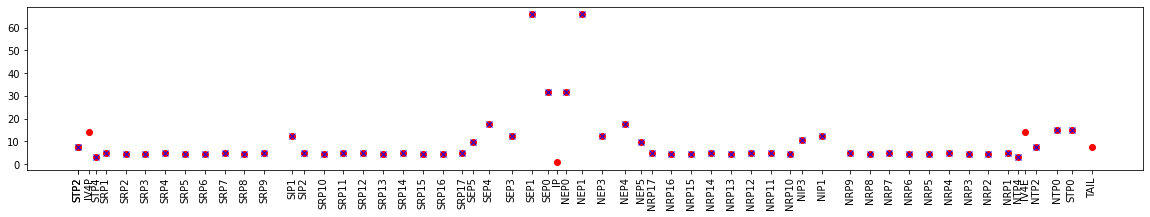

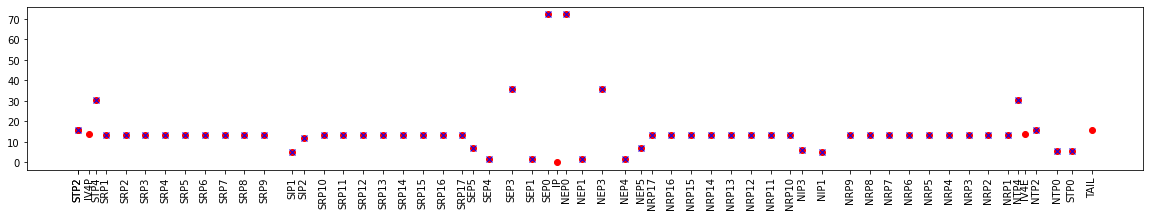

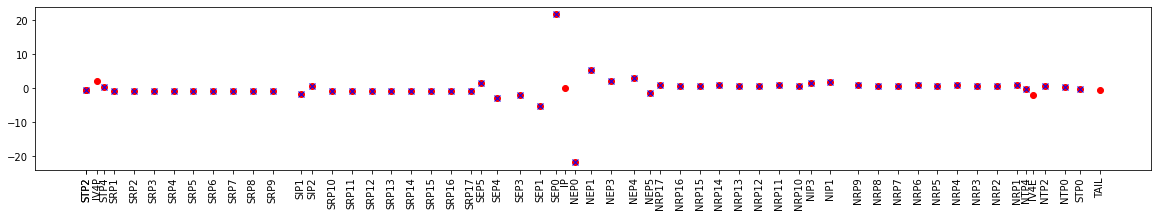

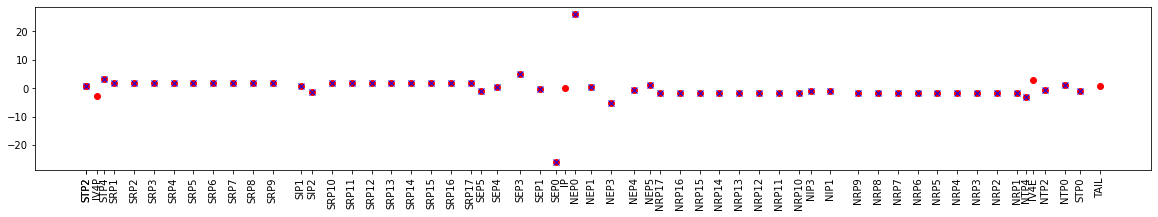

In [8]:
# Plot CS twiss parameters

# Note, 'HEAD' and 'STP2' locations are at the same position

# bx

plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.bx.cpu().numpy(), yerr=model.sigma_bx.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), yerr=model.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# by

plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.by.cpu().numpy(), yerr=model.sigma_by.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), yerr=model.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# ax

plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.ax.cpu().numpy(), yerr=model.sigma_ax.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.ax[model.monitor_index].cpu().numpy(), yerr=model.sigma_ax[model.monitor_index].cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# ay

plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.ay.cpu().numpy(), yerr=model.sigma_ay.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.ay[model.monitor_index].cpu().numpy(), yerr=model.sigma_ay[model.monitor_index].cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

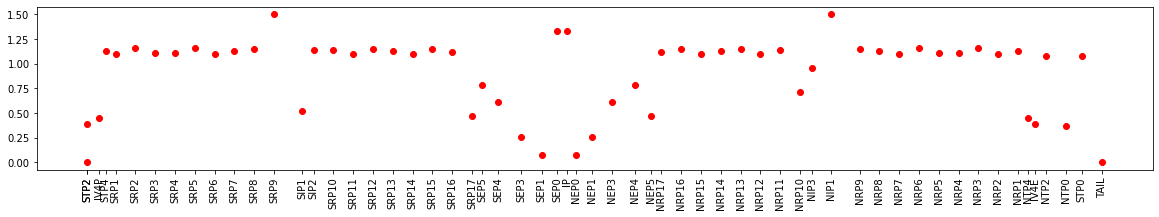

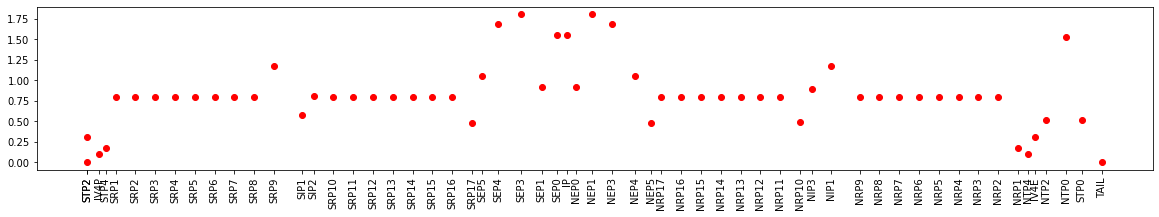

In [9]:
# Plot phase advance between locations

# phase_x

plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.phase_x.cpu().numpy(), yerr=model.sigma_x.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# phase_y

plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.phase_y.cpu().numpy(), yerr=model.sigma_y.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

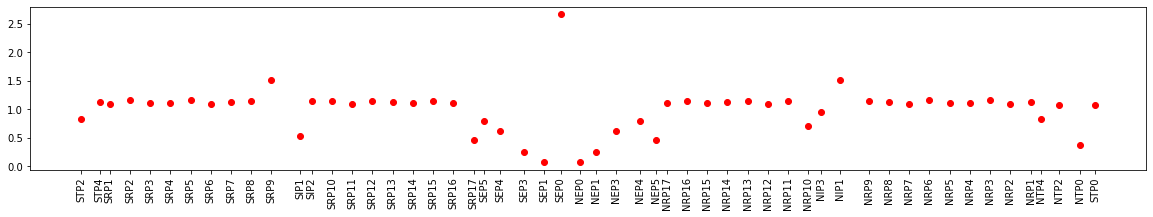

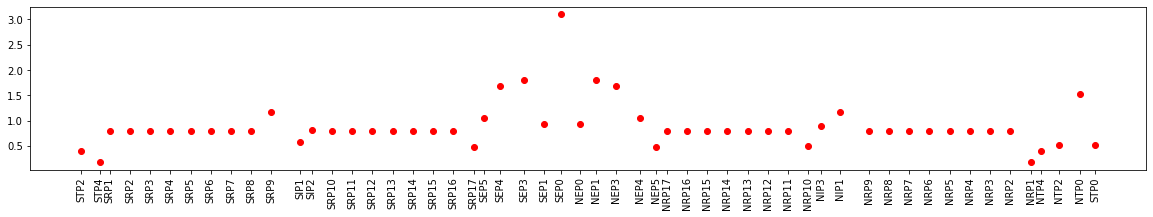

In [10]:
# Plot phase advance between monitor locations

# monitor_phase_x

plt.figure(figsize=(20, 3))
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.monitor_phase_x.cpu().numpy(), yerr=model.monitor_sigma_x.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.xticks(model.time[model.monitor_index].cpu().numpy(), model.monitor_name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# monitor_phase_y

plt.figure(figsize=(20, 3))
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.monitor_phase_y.cpu().numpy(), yerr=model.monitor_sigma_y.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.xticks(model.time[model.monitor_index].cpu().numpy(), model.monitor_name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

In [11]:
# Coupled model is specified by normalization matrices at locations and phase advances from start to location
# model.normal and model.sigma_normal

In [12]:
# Set coupled Model instance

model = Model(path='../config_coupled.yaml', model='coupled', dtype=dtype, device=device)
model.data_frame

,HEAD,STP2,IV4P,STP4,SRP1,SRP2,SRP3,SRP4,SRP5,SRP6,...,NRP4,NRP3,NRP2,NRP1,NTP4,IV4E,NTP2,NTP0,STP0,TAIL
TYPE,VIRTUAL,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,...,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,VIRTUAL
FLAG,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
JOIN,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
RISE,-1,8,-1,8,8,8,8,8,8,8,...,9,9,9,9,9,-1,9,9,9,-1
TIME,0.0,0.0,4.1535,6.667,10.190565,17.337624,24.484683,31.631742,38.778801,45.92586,...,314.367774,321.514833,328.661892,335.808951,339.332516,341.846016,345.999516,353.307016,358.767516,366.075016
N00,2.732666,2.732666,3.773373,1.766733,2.176169,2.135489,2.11755,2.180679,2.119061,2.133603,...,2.180679,2.11755,2.135489,2.176169,1.766733,3.773373,2.732666,3.881782,3.881782,2.732666
N01,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,...,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0
N02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N10,0.248227,0.248227,-0.518121,-0.21634,0.368243,0.337162,0.363621,0.361578,0.337528,0.369728,...,-0.361578,-0.363621,-0.337162,-0.368243,0.21634,0.518121,-0.248227,-0.04832,0.04832,0.248227


# Example-02: Table & model setup

In [13]:
# Table class is used as a container to store TbT (linear) parameters
# Frequency, amplitude and phase (including corresponding errors)
# TbT signal (data or work)  can be optionaly saved for each plane

In [14]:
# Set uncoupled Model instance

model = Model(path='../config_uncoupled.yaml', model='uncoupled', dtype=dtype, device=device)
model.data_frame

,HEAD,STP2,IV4P,STP4,SRP1,SRP2,SRP3,SRP4,SRP5,SRP6,...,NRP4,NRP3,NRP2,NRP1,NTP4,IV4E,NTP2,NTP0,STP0,TAIL
TYPE,VIRTUAL,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,...,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,VIRTUAL
FLAG,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
JOIN,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
RISE,-1,8,-1,8,8,8,8,8,8,8,...,9,9,9,9,9,-1,9,9,9,-1
TIME,0.0,0.0,4.1535,6.667,10.190565,17.337624,24.484683,31.631742,38.778801,45.92586,...,314.367774,321.514833,328.661892,335.808951,339.332516,341.846016,345.999516,353.307016,358.767516,366.075016
AX,-0.678322,-0.678322,1.955065,0.382216,-0.801359,-0.720007,-0.769987,-0.788485,-0.715242,-0.788853,...,0.788485,0.769987,0.720007,0.801359,-0.382216,-1.955065,0.678322,0.187567,-0.187567,-0.678322
BX,7.467461,7.467461,14.238343,3.121346,4.735711,4.560311,4.48402,4.755363,4.490419,4.552264,...,4.755363,4.48402,4.560311,4.735711,3.121346,14.238343,7.467461,15.068229,15.068229,7.467461
FX,0.0,0.0,0.385863,0.837521,1.965122,3.064451,4.221361,5.333373,6.443944,7.601242,...,45.781099,46.893111,48.050022,49.14935,50.276951,50.72861,51.114472,52.191233,52.562058,53.638818
AY,0.65444,0.65444,-2.759872,3.092008,1.839816,1.839551,1.84704,1.847097,1.839606,1.839758,...,-1.847097,-1.84704,-1.839551,-1.839816,-3.092008,2.759872,-0.65444,0.954725,-0.954725,0.65444
BY,15.854388,15.854388,13.855747,30.432785,13.261256,13.282406,13.324616,13.302293,13.260703,13.284183,...,13.302293,13.324616,13.282406,13.261256,30.432785,13.855747,15.854388,5.466362,5.466362,15.854388


In [15]:
# Load test data

data = pandas.read_pickle('../virtual_tbt.pkl.gz')

data_x = torch.tensor(data.X.to_list(), dtype=dtype, device=device)
data_y = torch.tensor(data.Y.to_list(), dtype=dtype, device=device)

# Set noise sigma for each BPM and plane

noise_x = 1.0E-6*(25.0 + 75.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 75.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

nux= 0.536883099, sigma_nux=1.72871682e-16
nux= 0.536883242, sigma_nux=1.39921383e-06, error=1.43311267e-07
nux=  0.53688291, sigma_nux=7.52436257e-07, error=1.88571924e-07


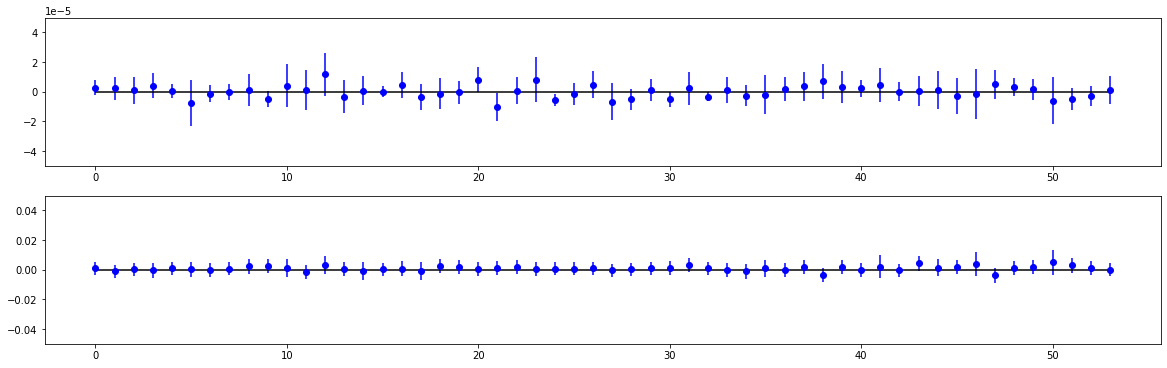

In [16]:
# Compute parameters for x plane

# Reference parameters

length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)
d = Data.from_data(w, data_x[:, :length])
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = mean(f.frequency), variance(f.frequency).sqrt()
frequency = 1.0 - frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, ref_ax, ref_fx = result.T
print(f'nux={frequency.item():12.9}, sigma_nux={spread.item():12.9}')

# Frequency

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, data_x[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)
l = Filter(d)
_, s = l.estimate_noise(limit=32)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
w = 1.0/s**2*torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2
nux, sigma_nux = weighted_mean(f.frequency), weighted_variance(f.frequency).sqrt()
nux = 1.0 - nux
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error={abs(frequency-nux).item():12.9}')
nux, sigma_nux = weighted_mean(f.frequency, weight=w), weighted_variance(f.frequency, weight=w).sqrt()
nux = 1.0 - nux
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error={abs(frequency-nux).item():12.9}')

# Amplitude

dec = Decomposition(d)
ax, sigma_ax, _ = dec.harmonic_amplitude(nux, length=128, order=1.0, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')

# Phase

dec = Decomposition(d)
fx, sigma_fx, _ = dec.harmonic_phase(nux, length=256, order=0.0, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-5.0E-2, +5.0E-2)
plt.show()

nux= 0.576774633, sigma_nux=1.82523846e-16
nux= 0.576774848, sigma_nux=1.40411115e-06, error=2.15134475e-07
nux= 0.576774769, sigma_nux=7.6930568e-07, error=1.35182934e-07


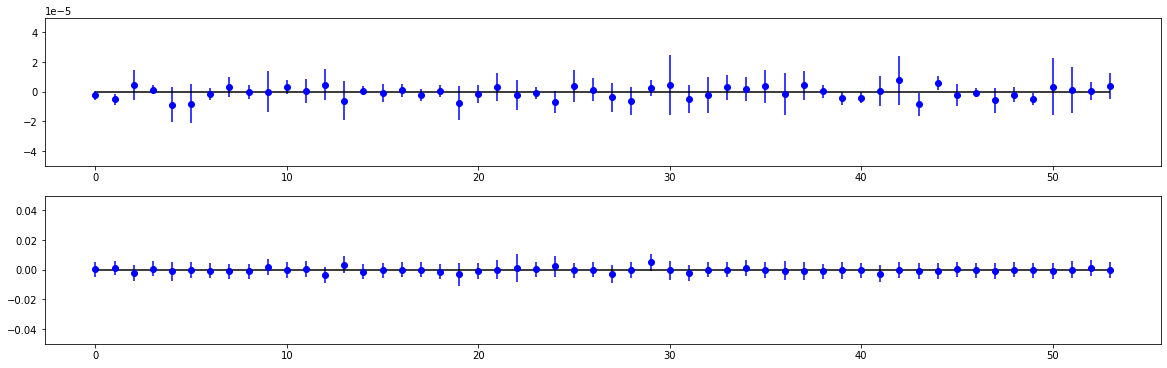

In [17]:
# Compute parameters for y plane

# Reference parameters

length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)
d = Data.from_data(w, data_y[:, :length])
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = mean(f.frequency), variance(f.frequency).sqrt()
frequency = 1.0 - frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, ref_ay, ref_fy = result.T
print(f'nuy={frequency.item():12.9}, sigma_nuy={spread.item():12.9}')

# Frequency

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, data_y[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)
l = Filter(d)
_, s = l.estimate_noise(limit=32)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
w = 1.0/s**2*torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2
nuy, sigma_nuy = weighted_mean(f.frequency), weighted_variance(f.frequency).sqrt()
nuy = 1.0 - nuy
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error={abs(frequency - nuy).item():12.9}')
nuy, sigma_nuy = weighted_mean(f.frequency, weight=w), weighted_variance(f.frequency, weight=w).sqrt()
nuy = 1.0 - nuy
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error={abs(frequency - nuy).item():12.9}')

# Amplitude

dec = Decomposition(d)
ay, sigma_ay, _ = dec.harmonic_amplitude(nuy, length=128, order=1.0, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')

# Phase

dec = Decomposition(d)
fy, sigma_fy, tmp = dec.harmonic_phase(nuy, length=256, order=0.0, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-5.0E-2, +5.0E-2)
plt.show()

In [18]:
# Set Table instance

table = Table(model.monitor_name, 
              nux, nuy, ax, ay, fx, fy, 
              sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
              dtype=dtype, device=device)
table

Table(54)

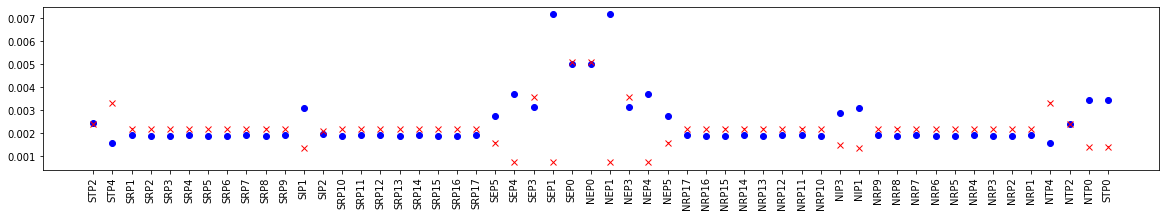

In [19]:
# Plot amplitudes

plt.figure(figsize=(20, 3))
plt.errorbar(range(table.size), table.ax.cpu().numpy(), yerr=table.sigma_ax.cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(range(table.size), table.ay.cpu().numpy(), yerr=table.sigma_ay.cpu().numpy(), fmt=' ', color='red', marker='x')
plt.xticks(range(table.size), table.name)
locs, labs = plt.xticks()
plt.setp(labs, rotation=90)
plt.show()

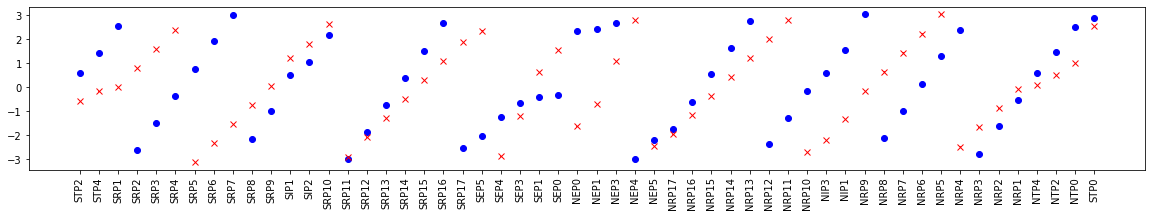

In [20]:
# Plot phases

plt.figure(figsize=(20, 3))
plt.errorbar(range(table.size), table.fx.cpu().numpy(), yerr=table.sigma_fx.cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(range(table.size), table.fy.cpu().numpy(), yerr=table.sigma_fy.cpu().numpy(), fmt=' ', color='red', marker='x')
plt.xticks(range(table.size), table.name)
locs, labs = plt.xticks()
plt.setp(labs, rotation=90)
plt.show()

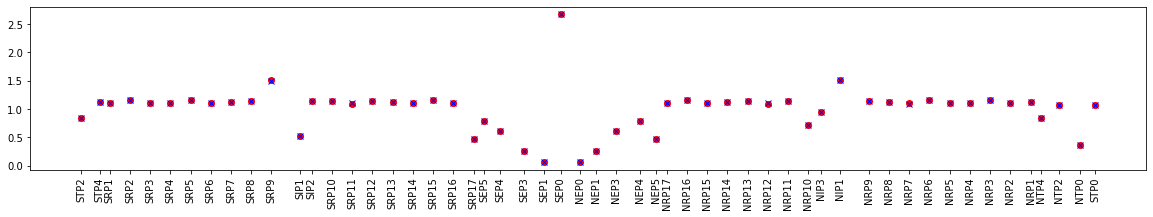

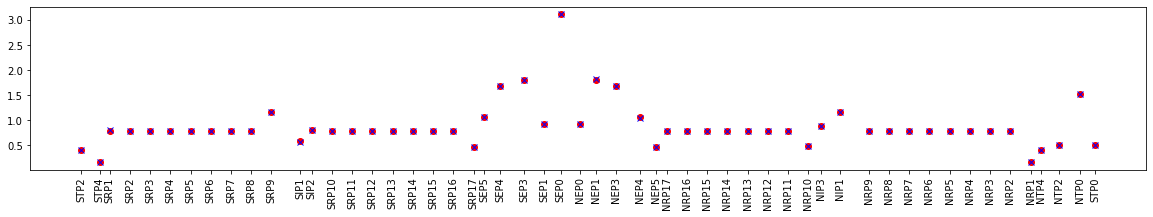

In [21]:
# Plot phase advance between monotors and compare with model

# Note, phase advance is mod two pi is both cases

# x

plt.figure(figsize=(20, 3))
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.monitor_phase_x.cpu().numpy(), yerr=model.monitor_sigma_x.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), table.phase_x.cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time[model.monitor_index].cpu().numpy(), model.monitor_name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# y

plt.figure(figsize=(20, 3))
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.monitor_phase_y.cpu().numpy(), yerr=model.monitor_sigma_y.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), table.phase_y.cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time[model.monitor_index].cpu().numpy(), model.monitor_name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# Example-03: Save/load model

In [22]:
# Model data can be saved using save method
# Attributes generated by make_error, make_transport and make_twiss are not saved

m1 = Model(path='../config_uncoupled.yaml')
m1.save(file='model.json')

In [23]:
# Model data can be loaded into existing model

m2 = Model()
m2.load(file='model.json')
print(torch.allclose(m1.phase_x, m2.phase_x))
print(torch.allclose(m1.phase_y, m2.phase_y))

True
True


In [24]:
# Model can be create from data

m3 = Model.from_file(file='model.json')
print(torch.allclose(m1.phase_x, m3.phase_x))
print(torch.allclose(m1.phase_y, m3.phase_y))

True
True


In [25]:
# Configuration (YAML file) can be saved using config_uncoupled & config_coupled instance methods
# By default, these methods save current relevant instance attributes
# But other attributes can be passed as parameters

model = Model(path='../config_coupled.yaml', model='coupled')
?model.config_coupled

Signature:
model.config_coupled(
    file: 'str',
    *,
    name: 'list' = None,
    kind: 'list' = None,
    flag: 'list' = None,
    join: 'list' = None,
    rise: 'list' = None,
    time: 'list' = None,
    normal: 'torch.Tensor' = None,
    fx: 'torch.Tensor' = None,
    fy: 'torch.Tensor' = None,
    sigma_normal: 'torch.Tensor' = None,
    sigma_fx: 'torch.Tensor' = None,
    sigma_fy: 'torch.Tensor' = None,
    epsilon: 'float' = 1e-12,
) -> 'None'
Docstring:
Save coupled model configuration to file.

Note, instance attribute is used corresponding named parameter is None.

Parameters
----------
file: str
    output file name
name: list
    location names
kind: list
    location kinds (expected kinds _virtual or _monitor)
flag: list
    flags
join: list
    join flags
rise: list
    starting turn
time: torch.Tensor
    position
fx: torch.Tensor
    x plane phase data
fy: torch.Tensor
    y plane phase data
sigma_fx: torch.Tensor
    x plane phase error
sigma_fy: torch.Tensor
   

# Example-04: Generation of combination (data for twiss from phase)

In [26]:
# Range limit can be passed to model on initialization
# This can be used to precompute data used for twiss parameters estimation from phase
# Once computed, model can be saved

In [27]:
# Set model instance

model = Model(path='../config.yaml', limit=8, error=True)
model.save()
del model

# limit -- maximum range limit
# error -- flag to compute model advance errors

# phase advance (and errors) are computed for all pairs combinations

In [28]:
# Load model with precomputed data

model = Model.from_file()
model

Model(path=../config.yaml, model=uncoupled)

In [29]:
# Maximum range limit

model.limit

8

In [30]:
# Range limit endpoints

model.count

# (0, 1)  -- limit=1
# (0, 6)  -- limit=2
# (0, 15) -- limit=3
# (0, 28) -- limit=4
# ...

tensor([  1,   6,  15,  28,  45,  66,  91, 120])

In [31]:
# Combinations

# combo -- index
# index -- index mod total number of locations

probe = 28
combo = model.combo[probe]
index = model.index[probe]

# upto limit=1

print(combo[0:1].cpu().tolist())
print(index[0:1].cpu().tolist())
print()

# upto limit=2

print(combo[0:6].cpu().tolist())
print(index[0:6].cpu().tolist())
print()

# only limit=2

print(combo[1:6].cpu().tolist())
print(index[1:6].cpu().tolist())
print()

[[[28, 27], [28, 29]]]
[[[28, 27], [28, 29]]]

[[[28, 27], [28, 29]], [[28, 26], [28, 27]], [[28, 26], [28, 29]], [[28, 26], [28, 30]], [[28, 29], [28, 30]], [[28, 27], [28, 30]]]
[[[28, 27], [28, 29]], [[28, 26], [28, 27]], [[28, 26], [28, 29]], [[28, 26], [28, 30]], [[28, 29], [28, 30]], [[28, 27], [28, 30]]]

[[[28, 26], [28, 27]], [[28, 26], [28, 29]], [[28, 26], [28, 30]], [[28, 29], [28, 30]], [[28, 27], [28, 30]]]
[[[28, 26], [28, 27]], [[28, 26], [28, 29]], [[28, 26], [28, 30]], [[28, 29], [28, 30]], [[28, 27], [28, 30]]]



In [32]:
# Phase advance and phase advance error (value for each combination for all locations)
# [[i, j], [i, k]]

print(model.fx_ij.shape)
print(model.fx_ik.shape)
print(model.sigma_fx_ij.shape)
print(model.sigma_fx_ik.shape)

torch.Size([120, 59])
torch.Size([120, 59])
torch.Size([120, 59])
torch.Size([120, 59])


In [33]:
# Compare with direct computation

probe = 28
value = 0
combo = model.combo[probe, value]
index = model.index[probe, value]

print(combo.cpu().tolist())
print(index.cpu().tolist())

phase, _ = Decomposition.phase_advance(*combo.T, model.nux, model.fx)
print(phase.cpu().tolist())

print([model.fx_ij[value, probe].cpu().item(), model.fx_ik[value, probe].cpu().item()])

[[28, 27], [28, 29]]
[[28, 27], [28, 29]]
[-1.3339903615135995, 1.33399036151393]
[-1.3339903615135995, 1.33399036151393]


In [34]:
# Given a range limit, other monitor locations within this limit are stored in table
# Print other locations for location zero
# Note, virtual locations are not included as other

model.table[0]

[-10, -9, -8, -7, -6, -4, -3, -2, 1, 3, 4, 5, 6, 7, 8, 9]

# Example-05: Uncoupled twiss parameters

In [35]:
# In this example twiss parameters are computed for uncoupled model
# Uncoupled model is generated from twiss data

In [36]:
# Load uncoupled model

model = Model(path='../config_uncoupled.yaml', model='uncoupled', dtype=dtype, device=device)

In [37]:
# Generate one-turn matrix at the 'HEAD' location

matrix = model.matrix(0, model.size)
print(matrix)

from harmonica.parameterization import is_symplectic
print(is_symplectic(matrix))

tensor([[-8.174741941785e-01, -1.715086192481e+00, 0.000000000000e+00, 0.000000000000e+00],
        [4.490851430614e-02, -1.129060750494e+00, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, -1.189482037211e+00, -7.354804784961e+00],
        [0.000000000000e+00, 0.000000000000e+00, 4.179161971876e-02, -5.822961370188e-01]],
       dtype=torch.float64)
True


In [38]:
# Wolski twiss parameters for a given input matrix can be computed with twiss_compute
# This method returns tuple of tunes, normalization matrix and Wolski twiss matrices for each plane
# Note, input matrix can have arbitrary even dimension

from harmonica.parameterization import twiss_compute
tunes, normal, wolski = twiss_compute(matrix)

In [39]:
# Compare tunes with model tunes
# Note, only fractional part can be computed from the one-turn matrix

print(torch.stack([model.nux - 8.0, model.nuy - 7.0]))
print(tunes)

tensor([5.368830987374e-01, 5.767746333258e-01], dtype=torch.float64)
tensor([5.368830987374e-01, 5.767746333258e-01], dtype=torch.float64)


In [40]:
# Check normalization matrix

# Standart gauge is used to condition normalization matrix
# M = N R N^-1, R -- rotation matrix
# N[0, 0] > 0, N[2, 2] > 0, ...
# N[0, 1] = N[2, 3] = ... = 0

print(normal)

mux, muy = 2.0*numpy.pi*tunes
rotation = torch.tensor([
    [mux.cos(), +mux.sin(), 0, 0],
    [-mux.sin(), mux.cos(), 0, 0],
    [0, 0, muy.cos(), +muy.sin()],
    [0, 0, -muy.sin(), muy.cos()]
])

print(torch.allclose(matrix, normal @ rotation @ normal.inverse()))

tensor([[2.732665537666e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
        [2.482271293933e-01, 3.659430640949e-01, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 3.981756917048e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, -1.643596756619e-01, 2.511454166673e-01]],
       dtype=torch.float64)
True


In [41]:
# Compute Wolski twiss matrices

from harmonica.parameterization import id_symplectic

print(wolski)

wx, wy = wolski
s = id_symplectic(2)

print(torch.allclose(matrix, wx @ s * mux.sin() - (wx @ s) @ (wx @ s) * mux.cos() + wy @ s * muy.sin() - (wy @ s) @ (wy @ s) * muy.cos()))

tensor([[[7.467460940747e+00, 6.783217220068e-01, 0.000000000000e+00, 0.000000000000e+00],
         [6.783217220068e-01, 1.955310339260e-01, 0.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00]],

        [[0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 0.000000000000e+00, 1.585438814646e+01, -6.544402754504e-01],
         [0.000000000000e+00, 0.000000000000e+00, -6.544402754504e-01, 9.008812329666e-02]]],
       dtype=torch.float64)
True


In [42]:
# Convert Wolski to CS and compare with model values

from harmonica.parameterization import wolski_to_cs

print(wolski_to_cs(wolski))
print(torch.stack([model.ax[0], model.bx[0], model.ay[0], model.by[0]]))

tensor([-6.783217220068e-01, 7.467460940747e+00, 6.544402754504e-01, 1.585438814646e+01],
       dtype=torch.float64)
tensor([-6.783217220068e-01, 7.467460940747e+00, 6.544402754504e-01, 1.585438814646e+01],
       dtype=torch.float64)


In [43]:
# Wolski twiss matrices can be propagated using transport matrices between locations

# Define transport matrices from 'HEAD' to each location
# Note, the last matrix is 'HEAD' to 'TAIL'

index = torch.arange(model.size, dtype=torch.int64, device=device)
transport = model.matrix(0*index, index)

# Propagate twiss

from harmonica.parameterization import twiss_propagate
table = twiss_propagate(wolski, transport)
print(table.shape)

# Compare with model

result = [torch.allclose(wolski_to_cs(w), torch.stack([model.ax[i], model.bx[i], model.ay[i], model.by[i]])) for i, w in enumerate(table)]
result.count(True)

torch.Size([59, 2, 4, 4])


59

In [44]:
# Phase advance between locations can be computed using twiss_phase_advance
# For given normalization matrix at the initial location and given transport matrices to other locations
# This function returns phase advance (mod two pi) and normalization matrix at the other locations

from harmonica.parameterization import twiss_phase_advance

advance, _ = twiss_phase_advance(normal, model.matrix('STP2', 'STP4').unsqueeze(0))
print(advance.squeeze())

print(torch.stack([model.fx[model.get_index('STP4')] - model.fx[model.get_index('STP2')], model.fy[model.get_index('STP4')] - model.fy[model.get_index('STP2')]]))

tensor([8.375209565894e-01, 4.070908562792e-01], dtype=torch.float64)
tensor([8.375209565894e-01, 4.070908562792e-01], dtype=torch.float64)


In [45]:
# Compute phase advance & normalization matrix between all adjacent locations and compare with model values

tunes, normal, wolski = twiss_compute(matrix)

total = torch.zeros_like(tunes)

for i in range(model.size):
    advance, normal = twiss_phase_advance(normal, model.matrix(i, i + 1).unsqueeze(0))
    advance = advance.squeeze()
    normal = normal.squeeze()
    total += mod(advance + 1.0E-12, 2.0*numpy.pi) - 1.0E-12
    j = int(mod(i + 1, model.size))
    ax, bx = model.ax[j], model.bx[j]
    ay, by = model.ay[j], model.by[j]
    nx = torch.tensor([[bx.sqrt(), 0], [-ax/bx.sqrt(), 1/bx.sqrt()]])
    ny = torch.tensor([[by.sqrt(), 0], [-ay/by.sqrt(), 1/by.sqrt()]])
    is_advance = torch.allclose(advance, mod(torch.stack([model.phase_x[i], model.phase_y[i]]), 2*numpy.pi))
    is_normal = torch.allclose(normal, torch.block_diag(nx, ny))
    print(f'{model.get_name(i):>6}{model.get_name(i + 1):>6} {is_advance} {is_normal}')

print()
print(total)
print(torch.stack([model.mux, model.muy]))

  HEAD  STP2 True True
  STP2  IV4P True True
  IV4P  STP4 True True
  STP4  SRP1 True True
  SRP1  SRP2 True True
  SRP2  SRP3 True True
  SRP3  SRP4 True True
  SRP4  SRP5 True True
  SRP5  SRP6 True True
  SRP6  SRP7 True True
  SRP7  SRP8 True True
  SRP8  SRP9 True True
  SRP9  SIP1 True True
  SIP1  SIP2 True True
  SIP2 SRP10 True True
 SRP10 SRP11 True True
 SRP11 SRP12 True True
 SRP12 SRP13 True True
 SRP13 SRP14 True True
 SRP14 SRP15 True True
 SRP15 SRP16 True True
 SRP16 SRP17 True True
 SRP17  SEP5 True True
  SEP5  SEP4 True True
  SEP4  SEP3 True True
  SEP3  SEP1 True True
  SEP1  SEP0 True True
  SEP0    IP True True
    IP  NEP0 True True
  NEP0  NEP1 True True
  NEP1  NEP3 True True
  NEP3  NEP4 True True
  NEP4  NEP5 True True
  NEP5 NRP17 True True
 NRP17 NRP16 True True
 NRP16 NRP15 True True
 NRP15 NRP14 True True
 NRP14 NRP13 True True
 NRP13 NRP12 True True
 NRP12 NRP11 True True
 NRP11 NRP10 True True
 NRP10  NIP3 True True
  NIP3  NIP1 True True
  NIP1  NRP

In [46]:
# Since twiss method can handle arbitrary even dimension matrices
# One can construct a block matrix from one-turn matrices at all locations and compute corresponding twiss parameters

index = torch.arange(model.size, dtype=torch.int64, device=device)
matrix = torch.block_diag(*model.matrix(index, index + model.size))
print(matrix.shape)

_, normal, table = twiss_compute(matrix)
print(table.shape)

# Exctact beta values and compare with model

print()
print(torch.allclose(model.bx, torch.stack([table[2*i + 0, 4*i + 0, 4*i + 0] for i in range(model.size)])))
print(torch.allclose(model.by, torch.stack([table[2*i + 1, 4*i + 2, 4*i + 2] for i in range(model.size)])))

print()
print(torch.allclose(model.bx, torch.stack([normal[4*i + 0, 4*i + 0]**2 for i in range(model.size)])))
print(torch.allclose(model.by, torch.stack([normal[4*i + 2, 4*i + 2]**2 for i in range(model.size)])))

torch.Size([236, 236])
torch.Size([118, 236, 236])

True
True

True
True


# Example-06: Coupled twiss parameters

In [47]:
# In this example twiss parameters are computed for coupled model
# A thin skew quadrupole is added to the one-turn matrix

In [48]:
# Load uncoupled model

model = Model(path='../config_uncoupled.yaml', model='uncoupled', dtype=dtype, device=device)

In [49]:
# Generate one-turn matrix at the 'HEAD' location

from harmonica.parameterization import is_symplectic

matrix = model.matrix(0, model.size)
print(matrix)
print(is_symplectic(matrix))

tensor([[-8.174741941785e-01, -1.715086192481e+00, 0.000000000000e+00, 0.000000000000e+00],
        [4.490851430614e-02, -1.129060750494e+00, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, -1.189482037211e+00, -7.354804784961e+00],
        [0.000000000000e+00, 0.000000000000e+00, 4.179161971876e-02, -5.822961370188e-01]],
       dtype=torch.float64)
True


In [50]:
# Generate thin skew quadrupole matrix

kn = torch.tensor(0.0E+0, dtype=dtype, device=device)
ks = torch.tensor(1.0E-3, dtype=dtype, device=device)

kick = model.matrix_kick(kn, ks)
print(kick)
print(is_symplectic(kick))

tensor([[1.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
        [-0.000000000000e+00, 1.000000000000e+00, 1.000000000000e-03, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00],
        [1.000000000000e-03, 0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]],
       dtype=torch.float64)
True


In [51]:
# Compute twiss

from harmonica.parameterization import twiss_compute
tunes, normal, wolski = twiss_compute(kick @ matrix)
print(normal)
print(wolski)

tensor([[ 2.733011863453e+00,  3.346974230610e-16, -3.905040791675e-02,
          3.670531147181e-16],
        [ 2.483160755541e-01,  3.657457500809e-01, -1.556901758468e-03,
         -1.056393628436e-02],
        [ 1.149739330129e-01, -4.531612285489e-16,  3.980640003650e+00,
          0.000000000000e+00],
        [-3.379408681657e-03,  3.587996081379e-03, -1.643330967144e-01,
          2.511122515631e-01]], dtype=torch.float64)
tensor([[[ 7.469353845777e+00,  6.786507803756e-01,  3.142251229121e-01,
          -9.235964018426e-03],
         [ 6.786507803756e-01,  1.954308270809e-01,  2.854987583677e-02,
           4.731328165488e-04],
         [ 3.142251229121e-01,  2.854987583677e-02,  1.321900527245e-02,
          -3.885439073879e-04],
         [-9.235964018426e-03,  4.731328165488e-04, -3.885439073879e-04,
           2.429411891765e-05]],

        [[ 1.524934358465e-03,  6.079764875449e-05, -1.554456159123e-01,
           6.417274460920e-03],
         [ 6.079764875449e-05,  1.14020

In [52]:
# Propagate twiss

# Generate transport matrices between locations

index = torch.arange(model.size, dtype=torch.int64, device=device)
transport = model.matrix(torch.zeros_like(index), index + 1)

# Apply error 

transport[-1] = kick @ transport[-1]

# Compute twiss

from harmonica.parameterization import twiss_propagate
table = twiss_propagate(wolski, transport).roll(1, 0)
print(table.shape)
print(torch.allclose(wolski, table[0]))

torch.Size([59, 2, 4, 4])
True


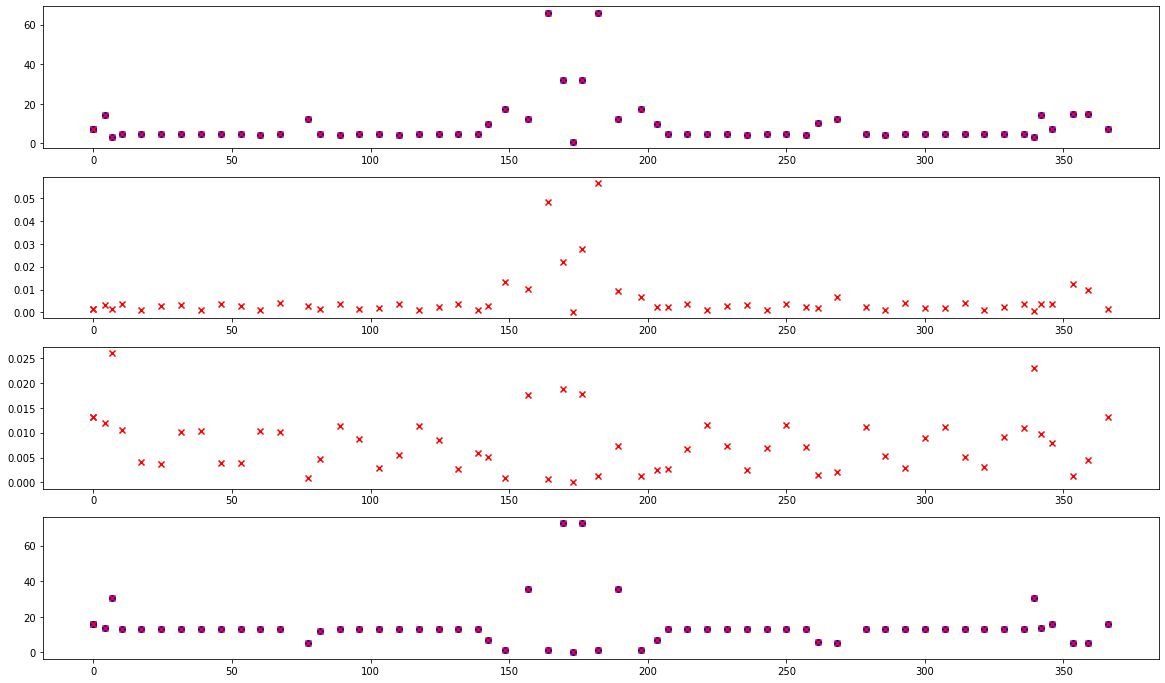

In [53]:
# Convert Wolski to Lebedev-Bogacz twiss and plot beta values

bxx = torch.zeros(model.size, dtype=dtype, device=device)
bxy = torch.zeros(model.size, dtype=dtype, device=device)
byx = torch.zeros(model.size, dtype=dtype, device=device)
byy = torch.zeros(model.size, dtype=dtype, device=device)

from harmonica.parameterization import wolski_to_lb
for i in range(model.size):
    _, bxx[i], _, bxy[i], _, byx[i], _, byy[i], *_ = wolski_to_lb(table[i])

plt.figure(figsize=(20, 3*4))

ax1 = plt.subplot(411)
ax1.scatter(model.time.cpu().numpy(),  model.bx.cpu().numpy(), marker='o', color='blue')
ax1.scatter(model.time.cpu().numpy(),  bxx.cpu().numpy(), marker='x', color='red')

ax2 = plt.subplot(412)
ax2.scatter(model.time.cpu().numpy(),  bxy.cpu().numpy(), marker='x', color='red')

ax3 = plt.subplot(413)
ax3.scatter(model.time.cpu().numpy(),  byx.cpu().numpy(), marker='x', color='red')

ax4 = plt.subplot(414)
ax4.scatter(model.time.cpu().numpy(),  model.by.cpu().numpy(), marker='o', color='blue')
ax4.scatter(model.time.cpu().numpy(),  byy.cpu().numpy(), marker='x', color='red')

plt.show()

In [54]:
# Generate trajectories from uncoupled and coupled one-turn matrices

m1 = matrix
tunes1, normal1, wolski1 = twiss_compute(m1)

m2 = kick @ matrix
tunes2, normal2, wolski2 = twiss_compute(m2)

initial = torch.tensor([
    [1.0E-3, 0.0, 1.0E-3, 0.0], 
    [2.0E-3, 0.0, 2.0E-3, 0.0], 
    [3.0E-3, 0.0, 3.0E-3, 0.0], 
    [4.0E-3, 0.0, 4.0E-3, 0.0], 
    [5.0E-3, 0.0, 5.0E-3, 0.0]], dtype=dtype, device=device)

length = 4096

table1 = torch.zeros((length, 4, len(initial)), dtype=dtype, device=device)
table2 = torch.zeros((length, 4, len(initial)), dtype=dtype, device=device)

table1[0] = initial.T
table2[0] = initial.T

floquet1 = torch.zeros((length, 4, len(initial)), dtype=dtype, device=device)
floquet2 = torch.zeros((length, 4, len(initial)), dtype=dtype, device=device)
floquet3 = torch.zeros((length, 4, len(initial)), dtype=dtype, device=device)

floquet1[0] = torch.matmul(normal1.inverse(), table1[0])
floquet2[0] = torch.matmul(normal2.inverse(), table2[0])
floquet3[0] = torch.matmul(normal1.inverse(), table2[0])

for i in range(1, length):
    
    table1[i] = torch.matmul(m1, table1[i - 1])
    table2[i] = torch.matmul(m2, table2[i - 1])
    
    floquet1[i] = torch.matmul(normal1.inverse(), table1[i])
    floquet2[i] = torch.matmul(normal2.inverse(), table2[i])
    floquet3[i] = torch.matmul(normal1.inverse(), table2[i])
    
table1 = table1.swapaxes(0, -1)
table2 = table2.swapaxes(0, -1)

floquet1 = floquet1.swapaxes(0, -1)
floquet2 = floquet2.swapaxes(0, -1)
floquet3 = floquet3.swapaxes(0, -1)

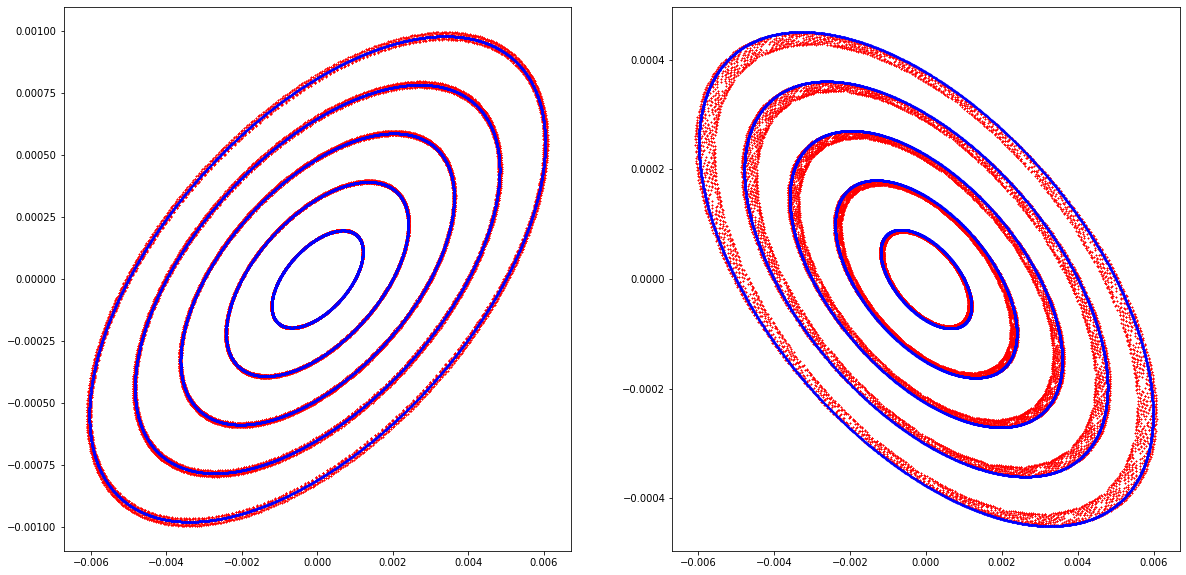

In [55]:
# Plot trajectories
# blue -- uncoupled, red -- coupled

plt.figure(figsize=(2*10, 10))

ax1 = plt.subplot(121)
for i in range(len(table1)):
    ax1.scatter(table2[i, 0], table2[i, 1], marker='x', s=1, color='red')
    ax1.scatter(table1[i, 0], table1[i, 1], marker='o', s=1, color='blue')

ax2 = plt.subplot(122)
for i in range(len(table1)):
    ax2.scatter(table2[i, 2], table2[i, 3], marker='x', s=1, color='red')
    ax2.scatter(table1[i, 2], table1[i, 3], marker='o', s=1, color='blue')

plt.show()

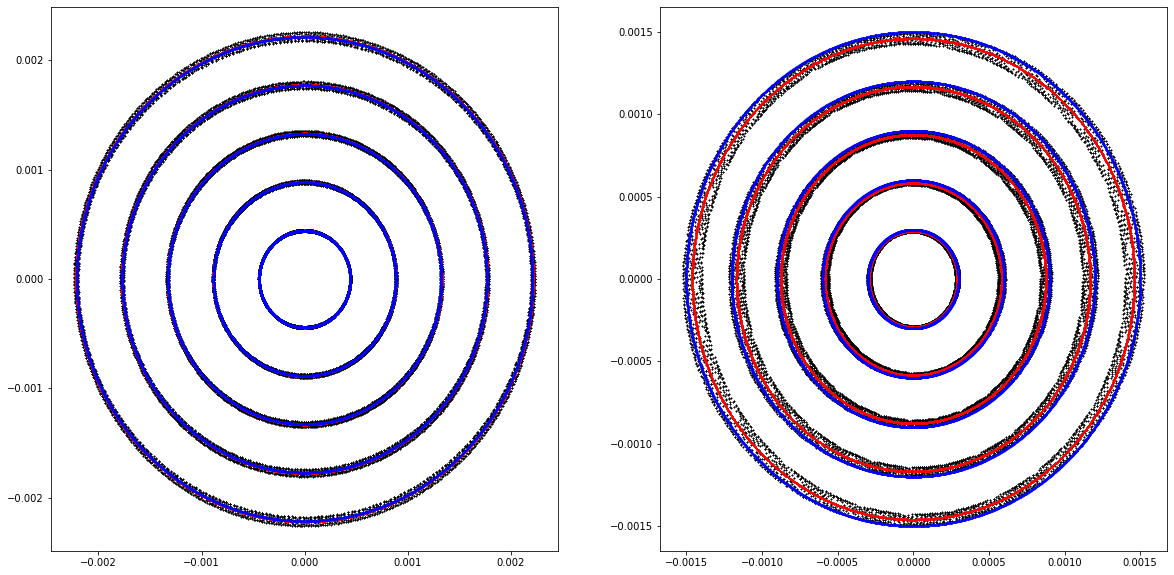

In [56]:
# Plot floquet trajectories
# Note, black points correspond to couped matrix with uncoupled normalization

plt.figure(figsize=(2*10, 10))

ax1 = plt.subplot(121)
for i in range(len(floquet1)):
    ax1.scatter(floquet3[i, 0], floquet3[i, 1], marker='x', s=1, color='black')
    ax1.scatter(floquet2[i, 0], floquet2[i, 1], marker='x', s=1, color='red')
    ax1.scatter(floquet1[i, 0], floquet1[i, 1], marker='o', s=1, color='blue')
    
ax2 = plt.subplot(122)
for i in range(len(floquet1)):
    ax2.scatter(floquet3[i, 2], floquet3[i, 3], marker='x', s=1, color='black')
    ax2.scatter(floquet2[i, 2], floquet2[i, 3], marker='x', s=1, color='red')
    ax2.scatter(floquet1[i, 2], floquet1[i, 3], marker='o', s=1, color='blue')
    
plt.show()

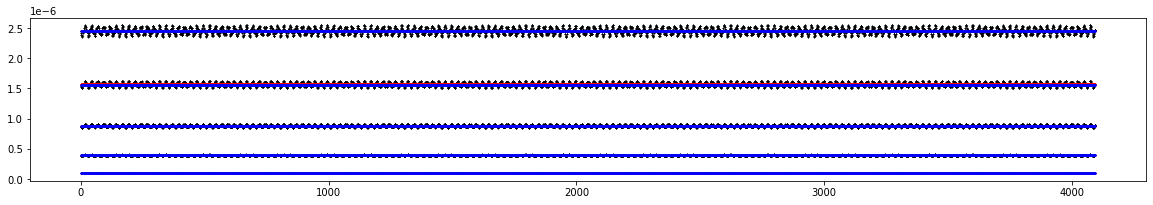

[5.0938682602304016e-21, 2.0375473040921606e-20, 5.43257598167013e-20, 8.150189216368643e-20, 1.2379618426319523e-19]
[4.541374724855888e-21, 1.8165498899423553e-20, 4.087813502405598e-20, 7.266199559769421e-20, 1.1846274856663304e-19]
[2.115069384307278e-09, 8.460277537229111e-09, 1.9035624458765497e-08, 3.3841110148916446e-08, 5.287673460768212e-08]


In [57]:
# Plot invariants for x plane
# Note, black points correspond to couped matrix with uncoupled normalization

invariant1 = 0.5*(floquet1[:, 0]**2 + floquet1[:, 1]**2)
invariant2 = 0.5*(floquet2[:, 0]**2 + floquet2[:, 1]**2)
invariant3 = 0.5*(floquet3[:, 0]**2 + floquet3[:, 1]**2)

plt.figure(figsize=(20, 3))

for i in range(len(invariant1)):
    plt.scatter(range(length), invariant3[i].cpu().numpy(), marker='x', s=1, color='black')
    plt.scatter(range(length), invariant2[i].cpu().numpy(), marker='x', s=1, color='red')
    plt.scatter(range(length), invariant1[i].cpu().numpy(), marker='o', s=1, color='blue')
    
plt.show()

# Compute spread

print(list(invariant1.std(-1).cpu().numpy()))
print(list(invariant2.std(-1).cpu().numpy()))
print(list(invariant3.std(-1).cpu().numpy()))

# Example-07: Wolski twiss parameters & model with errors

In [58]:
# Set uncoupled model

model = Model(path='../config_uncoupled.yaml', model='uncoupled', dtype=dtype, device=device)

In [59]:
# Twiss parameters are computed using transport matrices between locations
# Compute transport matrices

model.make_transport(error=False, exact=False)
print(model.size)
print(model.transport.shape)

# Each transport matrix is a matrix from start to given location

print(model.transport[10])
print(model.matrix(0, 10))

59
torch.Size([59, 4, 4])
tensor([[-9.548764884693e-01, 3.937221165950e+00, 0.000000000000e+00, 0.000000000000e+00],
        [-1.808099116458e-01, -3.017263408762e-01, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 4.911528440888e-02, -1.179288864388e+01],
        [0.000000000000e+00, 0.000000000000e+00, 7.533248095164e-02, 2.272458405024e+00]],
       dtype=torch.float64)
tensor([[-9.548764884693e-01, 3.937221165950e+00, 0.000000000000e+00, 0.000000000000e+00],
        [-1.808099116458e-01, -3.017263408762e-01, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 4.911528440888e-02, -1.179288864388e+01],
        [0.000000000000e+00, 0.000000000000e+00, 7.533248095164e-02, 2.272458405024e+00]],
       dtype=torch.float64)


In [60]:
# One-turn matrix at 'HEAD' location is also computed and attached
# Twiss parameters are computed from one-turn matrix at 'HEAD' location
# Parameters at other locations are computed then

print(model.turn)
print(model.matrix(0, model.size))
print(torch.allclose(model.turn, model.matrix(0, model.size)))

tensor([[-8.174741941785e-01, -1.715086192481e+00, 0.000000000000e+00, 0.000000000000e+00],
        [4.490851430614e-02, -1.129060750494e+00, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, -1.189482037211e+00, -7.354804784961e+00],
        [0.000000000000e+00, 0.000000000000e+00, 4.179161971876e-02, -5.822961370188e-01]],
       dtype=torch.float64)
tensor([[-8.174741941785e-01, -1.715086192481e+00, 0.000000000000e+00, 0.000000000000e+00],
        [4.490851430614e-02, -1.129060750494e+00, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, -1.189482037211e+00, -7.354804784961e+00],
        [0.000000000000e+00, 0.000000000000e+00, 4.179161971876e-02, -5.822961370188e-01]],
       dtype=torch.float64)
True


In [61]:
# Compute twiss parameters at all locations
# Note, if flag is True, one-turn matrix is stable, else False and other parameters are not computed

model.make_twiss()
print(model.is_stable)

# Tunes from accumulated phase advance between locations

print(model.out_tune)
print(torch.stack([model.nux, model.nuy]))
print()

# Fractional tunes

print(model.out_tune_fractional)
print(mod(torch.stack([model.nux, model.nuy]), 1.0))
print()

# Wolski twiss matrices

print(model.out_wolski.shape)
print()

# CS twiss

print(model.out_cs.shape)
print()

# Phase advance between locations (i, i + 1)

print(model.out_advance.shape)
print()

# Normalization matrices

print(model.out_normal.shape)
print()

True
tensor([8.536883098737e+00, 7.576774633326e+00], dtype=torch.float64)
tensor([8.536883098737e+00, 7.576774633326e+00], dtype=torch.float64)

tensor([5.368830987374e-01, 5.767746333258e-01], dtype=torch.float64)
tensor([5.368830987374e-01, 5.767746333258e-01], dtype=torch.float64)

torch.Size([59, 2, 4, 4])

torch.Size([59, 4])

torch.Size([59, 2])

torch.Size([59, 4, 4])



In [62]:
# Compare computed twiss with model

from harmonica.parameterization import wolski_to_cs, cs_normal, matrix_rotation

# Twiss

print(all(torch.allclose(wolski_to_cs(model.out_wolski[i]), torch.stack([model.ax[i], model.bx[i], model.ay[i], model.by[i]])) for i in range(model.size)))

# Normalization matrix

print(all(torch.allclose(model.out_normal[i], cs_normal(model.ax[i], model.bx[i], model.ay[i], model.by[i])) for i in range(model.size)))

# Transport normalization

print(all(torch.allclose(model.matrix(i, i + 1), model.out_normal[int(mod(i + 1, model.size))] @ matrix_rotation(model.out_advance[i].unsqueeze(0)).squeeze() @ model.out_normal[i].inverse()) for i in range(model.size)))

# Adjacent advance

print(torch.allclose(mod(torch.stack([model.phase_x, model.phase_y]), 2.0*numpy.pi, -numpy.pi), model.out_advance.T))

True
True
True
True


In [63]:
# Quadrupole errors can be added to each transport matrix (at the entrance)
# D(1/2*L) @ K(KN, KS) @ D(1/2*L), default length is zero, i.e. thin quadrupole kick is added

# Set errors

# If float is passed, errors for each location are generated using input as sigma
# Errors are stored in self.error_kn and self.error_ks
# Generated matrices are stored in self.error_matrix

model.make_error(1.0E-3, 1.0E-3, length=0.01)

print(model.error_kn.shape)
print(model.error_ks.shape)
print(model.error_matrix.shape)

# Check error matrix

index = 10
kn = model.error_kn[index]
ks = model.error_ks[index]
kl = 0.5*model.error_length[index]
print(torch.allclose(model.error_matrix[index], model.matrix_drif(kl) @ model.matrix_kick(kn, ks) @ model.matrix_drif(kl)))

# Compute transport

model.make_transport(error=True, exact=False)

# Compute twiss for model with errors

model.make_twiss()
print(model.is_stable)

torch.Size([59])
torch.Size([59])
torch.Size([59, 4, 4])
True
True


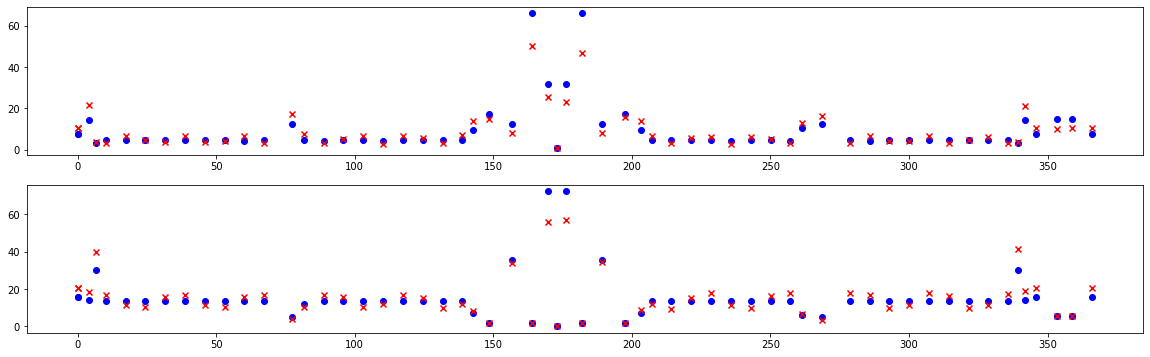

In [64]:
# Compare twiss

bx = torch.zeros(model.size, dtype=dtype, device=device)
by = torch.zeros(model.size, dtype=dtype, device=device)

from harmonica.parameterization import wolski_to_lb
for i in range(model.size):
    _, bx[i], _, _, _, _, _, by[i], *_ = wolski_to_lb(model.out_wolski[i])
    
plt.figure(figsize=(20, 2*3))

ax1 = plt.subplot(211)
ax1.scatter(model.time.cpu().numpy(),  model.bx.cpu().numpy(), marker='o', color='blue')
ax1.scatter(model.time.cpu().numpy(),  bx.cpu().numpy(), marker='x', color='red')

ax2 = plt.subplot(212)
ax2.scatter(model.time.cpu().numpy(),  model.by.cpu().numpy(), marker='o', color='blue')
ax2.scatter(model.time.cpu().numpy(),  by.cpu().numpy(), marker='x', color='red')

plt.show()

In [65]:
# Minimum tune approach

from harmonica.parameterization import id_symplectic
S = id_symplectic(1)
M = model.turn
MUA, MUB = 2.0*numpy.pi*model.out_tune
A, B, C, D = M[0:2, 0:2], M[0:2, 2:4], M[2:4, 0:2], M[2:4, 2:4]
print(torch.allclose(M, torch.vstack([torch.hstack([A, B]), torch.hstack([C, D])])))
print(((C - S @ B.T @ S).det().abs().sqrt()/(numpy.pi*(MUA.sin() + MUB.sin()))).item())

True
-0.016144685895818595


In [66]:
# Save configuration for model with errors

model.config_coupled('test.yaml', normal=model.out_normal, sigma_normal=torch.zeros_like(model.out_normal))

# Load saved configuration and compare normalization matrices

test = Model(path='test.yaml', model='coupled')
torch.allclose(model.out_normal, test.normal)

True

# Example-08: Generation of test trajectories

In [67]:
# Test trajectories at locations can be generated for a given initial condition
# Set uncoupled model

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)

# Generate errors

model.make_error(1.0E-3, 1.0E-3)

# Compute transport matrices

model.make_transport(error=True, exact=False)

# Compute twiss (not used in generation of trajectories)

model.make_twiss()
print(model.is_stable)

True


In [68]:
# Set initial condition

state = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

In [69]:
# Initial condition can be propagated using map_transport method

print(torch.allclose(model.map_transport(state, 0, model.size, error=False), model.matrix(0, model.size) @ state))
print(torch.allclose(model.map_transport(state, 0, model.size, error=True), model.turn @ state))

True
True


In [70]:
# Trajectories can be generated by state propagation or using transport matrices
# Without corrector errors, trajectories are the same, but using transport matrices is faster

# Set number of iterations

length = 2**6

# Generate trajectories

trj1 =  model.make_trajectory(state, length, error=True, transport=False)
trj2 =  model.make_trajectory(state, length, error=True, transport=True)
print(trj1.shape)
print(trj2.shape)
print(torch.allclose(trj1, trj2))

torch.Size([59, 64, 4])
torch.Size([59, 64, 4])
True


torch.Size([59, 4096, 4])


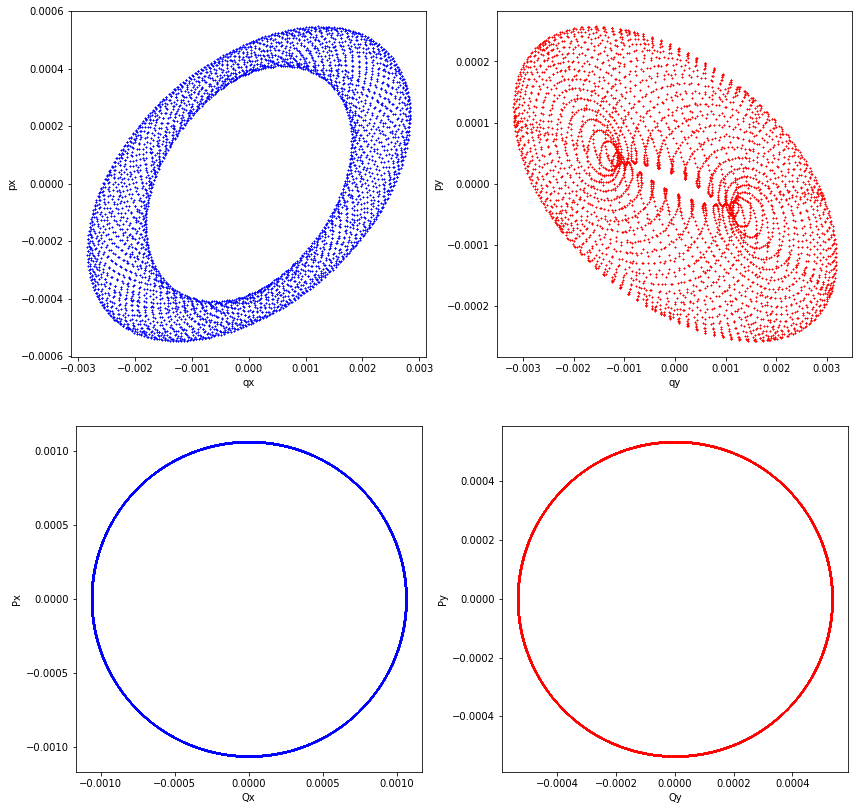

7.592689870778247e-18
2.5620564863206713e-19


In [71]:
# Generate trajectories using transport matrices

length = 2**12
trajectory =  model.make_trajectory(state, length, error=True, transport=True)
print(trajectory.shape)

# Plot trajectory and floquet trajectory for given location index

index = 0

qx, px, qy, py = trajectory[index].T.cpu().numpy()
Qx, Px, Qy, Py = (model.out_normal[index].inverse() @ trajectory[index].T).cpu().numpy()

plt.figure(figsize=(2*7, 2*7))

# qx-px

ax1 = plt.subplot(221)
ax1.scatter(qx, px, marker='x', s=1, color='blue')
ax1.set_xlabel('qx')
ax1.set_ylabel('px')
ax1.set_aspect('auto')

# qy-py

ax2 = plt.subplot(222)
ax2.scatter(qy, py, marker='x', s=1, color='red')
ax2.set_xlabel('qy')
ax2.set_ylabel('py')
ax2.set_aspect('auto')

# Qx-Px

ax3 = plt.subplot(223)
ax3.scatter(Qx, Px, marker='x', s=1, color='blue')
ax3.set_xlabel('Qx')
ax3.set_ylabel('Px')
ax3.set_aspect('equal')

# Qy-Py

ax4 = plt.subplot(224)
ax4.scatter(Qy, Py, marker='x', s=1, color='red')
ax4.set_xlabel('Qy')
ax4.set_ylabel('Py')
ax4.set_aspect('equal')

plt.show()

# Conservation of invariants

print((Qx**2 + Px**2).std().item())
print((Qy**2 + Py**2).std().item())

In [72]:
# Trajectories are generated at all locations

print(model.size)
print(trajectory.shape)
print()

# Trajectories at montor locations

print(model.monitor_count)
print(trajectory[model.monitor_index].shape)
print()

59
torch.Size([59, 4096, 4])

54
torch.Size([54, 4096, 4])



# Example-09: Linear invariants

In [73]:
# In this example uncoupled and coupled linear invariants (actions) are computed

In [74]:
# Generate test trajectories for uncoupled model

# Set uncoupled model

model = Model(path='../config_uncoupled.yaml', model='uncoupled', dtype=dtype, device=device)

# Set errors

model.make_error(1.0E-3, 1.0E-3, length=0.01)

# Compute transport

model.make_transport(error=True, exact=False)

# Compute twiss (not used in generation of trajectories)

model.make_twiss()
print(model.is_stable)

# Set initial condition

state = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**12

# Generate trajectories

trajectory =  model.make_trajectory(state, length, error=True, transport=True)
print(trajectory.shape)

True
torch.Size([59, 4096, 4])


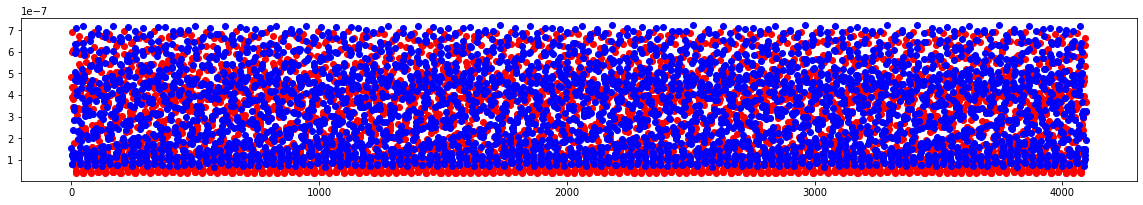

X: mean=2.94451181e-07, std=1.91301486e-07
Y: mean=3.40983093e-07, std=1.86663682e-07


In [75]:
# Compute uncoupled invariant

from harmonica.parameterization import invariant_uncoupled

index = 0
jx, jy = invariant_uncoupled(model.out_normal[index], trajectory[index])

plt.figure(figsize=(20, 3))
plt.scatter(range(4096), jx, color='red')
plt.scatter(range(4096), jy, color='blue')
plt.show()

print(f'X: mean={jx.mean().item():12.9}, std={jx.std().item():12.9}')
print(f'Y: mean={jy.mean().item():12.9}, std={jy.std().item():12.9}')

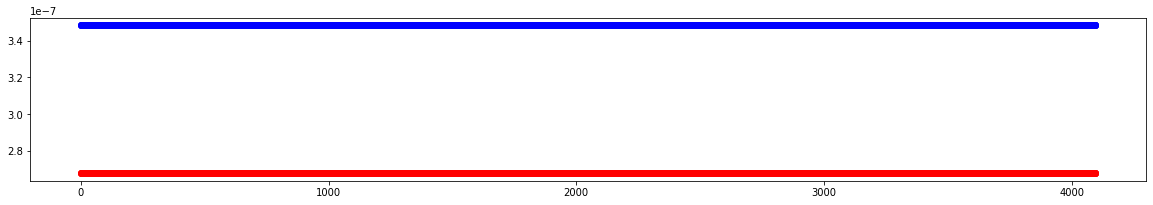

X: mean=2.67680609e-07, std=6.1501144e-19
Y: mean=3.48512009e-07, std=2.39702377e-18


In [76]:
# Compute coupled invariant (same as uncoupled in this case)

from harmonica.parameterization import invariant_coupled

index = 0
jx, jy = invariant_coupled(model.out_normal[index], trajectory[index])

plt.figure(figsize=(20, 3))
plt.scatter(range(4096), jx, color='red')
plt.scatter(range(4096), jy, color='blue')
plt.show()

print(f'X: mean={jx.mean().item():12.9}, std={jx.std().item():12.9}')
print(f'Y: mean={jy.mean().item():12.9}, std={jy.std().item():12.9}')

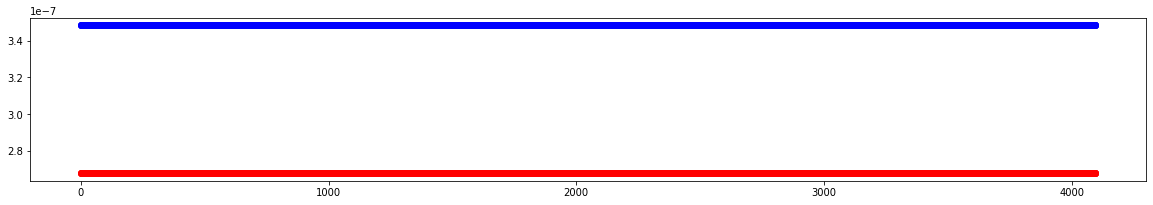

X: mean=2.67680609e-07, std=6.15042472e-19
Y: mean=3.48512009e-07, std=2.39705694e-18


In [77]:
# Both invariant_uncoupled & invariant_coupled use elements of the input normalization matrix to compute invariants
# Normalization matrix can be used directly

from harmonica.parameterization import invariant

index = 0
jx, jy = invariant(model.out_normal[index], trajectory[index])

plt.figure(figsize=(20, 3))
plt.scatter(range(4096), jx, color='red')
plt.scatter(range(4096), jy, color='blue')
plt.show()

print(f'X: mean={jx.mean().item():12.9}, std={jx.std().item():12.9}')
print(f'Y: mean={jy.mean().item():12.9}, std={jy.std().item():12.9}')

# Example-10: Closed orbit

In [78]:
# Corrector errors can be added to each sector between locations
# Thin corrector kicks are applied at the entrance of each sector

# Closed orbit is computed by make_trasport using analytical expression for closed orbit
# If exact falg is true, orbit is computed by minimize with initial guess from the analytical expression
# For linear system, the analytical expression gives exact result, no need to use minimize

# Transport matrices are computed around closed orbit
# But for linear system, thin correctors do not change transport matrices

In [79]:
# Generate test trajectories for uncoupled model

# Set uncoupled model

model = Model(path='../config_uncoupled.yaml', model='uncoupled', dtype=dtype, device=device)

# Set errors

model.make_error(1.0E-3, 1.0E-3, length=0.01, angle_x=1.0E-3, angle_y=1.0E-3)

# Compute transport

model.make_transport(error=True, exact=False)

# Compute twiss (not used in generation of trajectories)

model.make_twiss()
print(model.is_stable)

# Set initial condition

state = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(state, length, error=True, transport=False)
print(trajectory.shape)

True
torch.Size([59, 1024, 4])


In [80]:
# make_transport sets orbit attribute (closed orbit for each location)

print(model.orbit.shape)

# Test closed orbit

orbit, *_ = model.orbit
print(orbit)
print(model.map_transport(orbit, 0, model.size))
print(torch.allclose(orbit, model.map_transport(orbit, 0, model.size)))
print(torch.allclose(model.orbit, model.make_trajectory(orbit, 1).squeeze(1)))

torch.Size([59, 4])
tensor([2.653185250932e-03, 2.672341777386e-03, -4.766147591560e-02, 1.788206532788e-03],
       dtype=torch.float64)
tensor([2.653185250932e-03, 2.672341777386e-03, -4.766147591560e-02, 1.788206532788e-03],
       dtype=torch.float64)
True
True


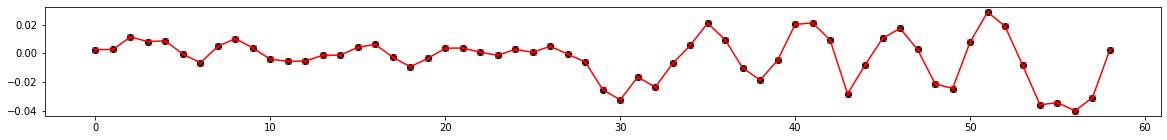

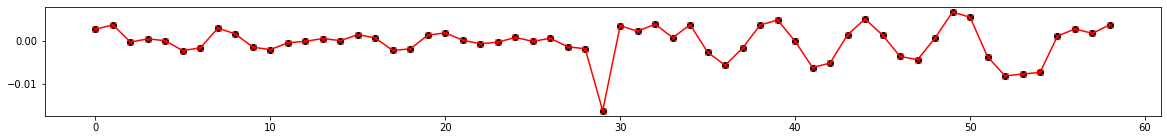

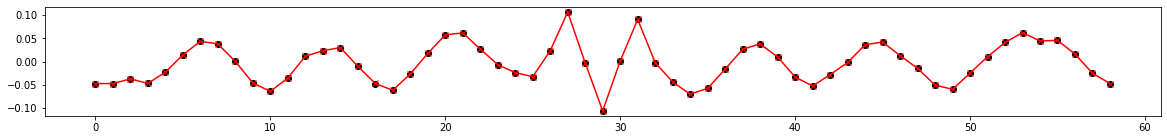

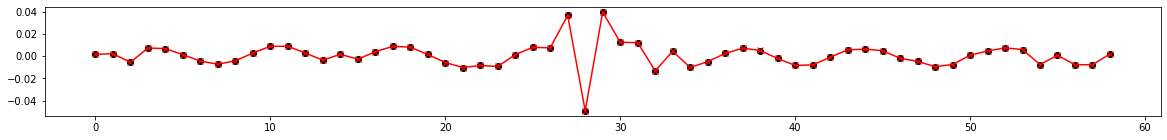

In [81]:
# Compare closed orbits

for plane in range(len(state)):
    plt.figure(figsize=(20, 2))
    plt.plot(range(model.size), model.orbit[:, plane], color='red', marker='x')
    plt.scatter(range(model.size), trajectory[..., plane].mean(1), color='black', marker='o')
    plt.show()

# Example-11: Orbit responce

In [1]:
# Import

import numpy
import pandas
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.statistics import mean, variance
from harmonica.statistics import weighted_mean, weighted_variance
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Orbit responce matrix can be computed using model.make_responce method
# Responce matrix is computed from difference orbits, closed orbits are computed using linear transport matrices

In [4]:
# Set model

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)

# Set corrector & monitor locations

lc = model.monitor_index
lm = model.monitor_index

# Set quadrupole errors

kn = 5.0E-3*torch.randn(model.size, dtype=dtype, device=device)
ks = 5.0E-3*torch.randn(model.size, dtype=dtype, device=device)
kl = 0.01

# Set corrector errors (only at corrector locations)

cx = torch.zeros(model.size, dtype=dtype, device=device)
cy = torch.zeros(model.size, dtype=dtype, device=device)

cx[lc] += 1.0E-3*torch.randn(len(lc), dtype=dtype, device=device)
cy[lc] += 1.0E-3*torch.randn(len(lc), dtype=dtype, device=device)

# Make errors

model.make_error(kn, ks, length=kl, angle_x=cx, angle_y=cy)

# Make transport

model.make_transport(error=True, exact=False, method='BFGS', tol=1.0E-12)

In [5]:
# Compute responce matrix using model transport and transport with errors

responce_model = model.make_responce(lc, lm, model.matrix)
responce_error = model.make_responce(lc, lm, model.matrix_transport)

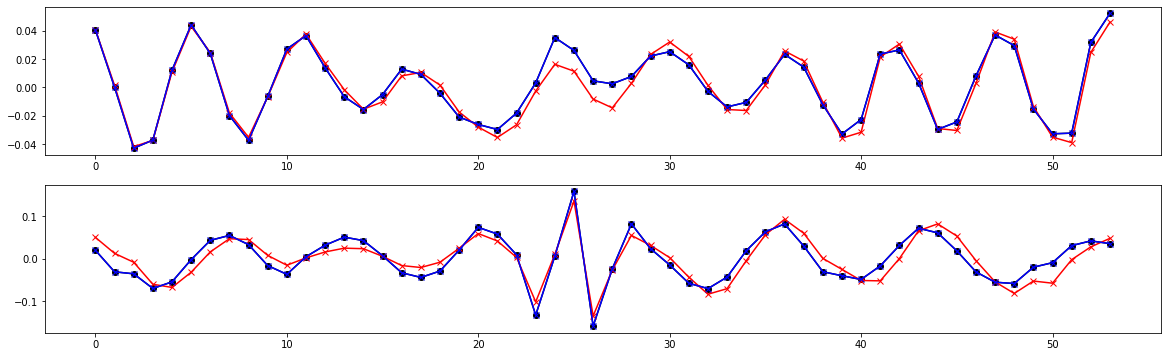

In [6]:
# Compare closed orbits

angle = torch.hstack([cx[lc], cy[lc]])

x_model, y_model = (responce_model @ angle).reshape(2, -1)
x_error, y_error = (responce_error @ angle).reshape(2, -1)

x, _, y, _ = model.orbit[lm].T


plt.figure(figsize=(20, 2*3))

ax = plt.subplot(211)
ax.plot(range(len(lm)), x, color='black', marker='o')
ax.plot(range(len(lm)), x_model, color='red', marker='x')
ax.plot(range(len(lm)), x_error, color='blue', marker='x')

ax = plt.subplot(212)
ax.plot(range(len(lm)), y, color='black', marker='o')
ax.plot(range(len(lm)), y_model, color='red', marker='x')
ax.plot(range(len(lm)), y_error, color='blue', marker='x')

plt.show()

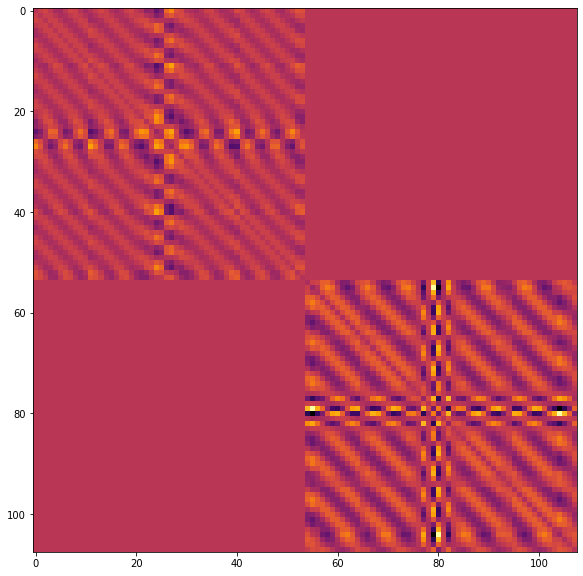

In [7]:
# Plot responce matrix (model)

plt.figure(figsize=(10, 10))
plt.imshow(responce_model.cpu().numpy(), cmap='inferno')
plt.show()

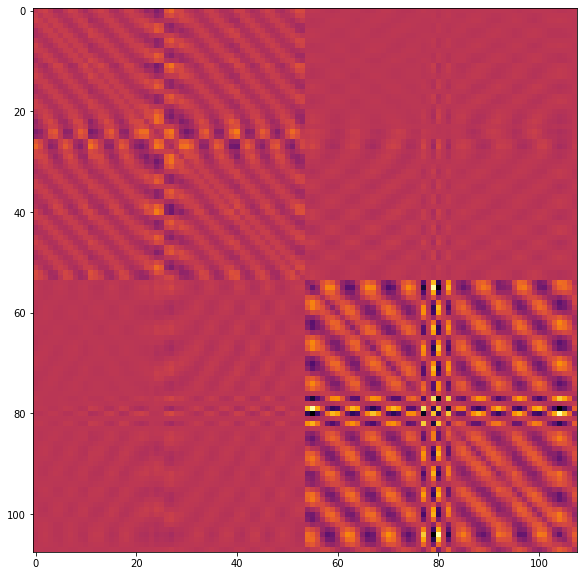

In [8]:
# Plot responce matrix (error)

plt.figure(figsize=(10, 10))
plt.imshow(responce_error.cpu().numpy(), cmap='inferno')
plt.show()

# Example-12: SKIF FOFB

In [1]:
# Import

import re
import numpy
import pandas
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.statistics import mean, variance
from harmonica.statistics import weighted_mean, weighted_variance
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# In this example orbit responce is computed for SKIF fast correctors
# Errors are added to standalone quadrupoles

True


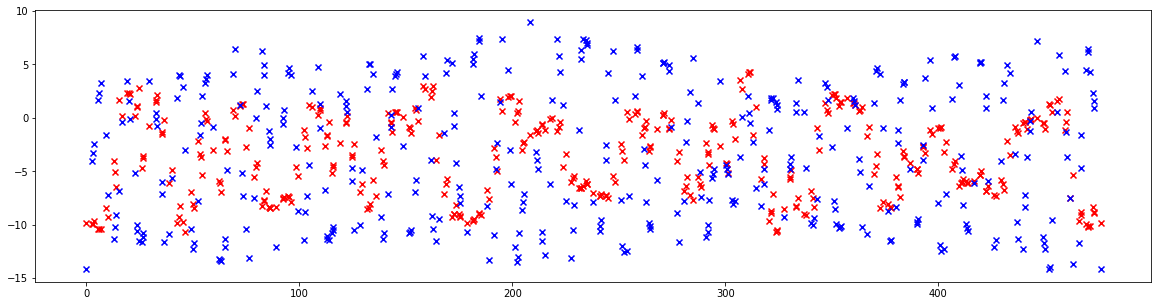

In [4]:
# Set model

model = Model(path='../fast.yaml', model='uncoupled', dtype=dtype, device=device)

# Set monitor locations (ID monitors)

lm = [model.name.index(name) for name in model.name if re.match(r'^(MA).*\.PKA[1, 2]', name)]

# Set fast corrector locations

lc = [model.name.index(name) for name in model.name if re.match(r'^(MA).*\.CB.*\.CX', name)]

# Set standalone quadrupole locations

lq = [model.name.index(name) for name in model.name if re.match(r'^(MA).*\.Q[F, D]', name)]

# Set quadrupole errors

kn = torch.zeros(model.size, dtype=dtype, device=device)
ks = torch.zeros(model.size, dtype=dtype, device=device)
kl = 0.0

kn[lq] += 1.0E-3*torch.randn(len(lq), dtype=dtype, device=device)
ks[lq] += 1.0E-3*torch.randn(len(lq), dtype=dtype, device=device)

# Set corrector errors

cx = torch.zeros(model.size, dtype=dtype, device=device)
cy = torch.zeros(model.size, dtype=dtype, device=device)

cx[lq] += 10.0E-6*torch.randn(len(lq), dtype=dtype, device=device)
cy[lq] += 10.0E-6*torch.randn(len(lq), dtype=dtype, device=device)

# Make errors

model.make_error(kn, ks, length=kl, angle_x=cx, angle_y=cy)

# Make transport

model.make_transport(error=True, exact=False, method='BFGS', tol=1.0E-12)

# Make twiss

model.make_twiss()
print(model.is_stable)

# Compare twiss

AX, BX, AY, BY = model.out_cs.T

plt.figure(figsize=(20, 5))
plt.scatter(model.time.cpu().numpy(), 100*(BX - model.bx)/model.bx, color='red', marker='x')
plt.scatter(model.time.cpu().numpy(), 100*(BY - model.by)/model.by, color='blue', marker='x')
plt.show()

In [5]:
# Compute responce matrix using model transport and transport with errors

responce_model = model.make_responce(lc, lm, model.matrix)
responce_error = model.make_responce(lc, lm, model.matrix_transport)

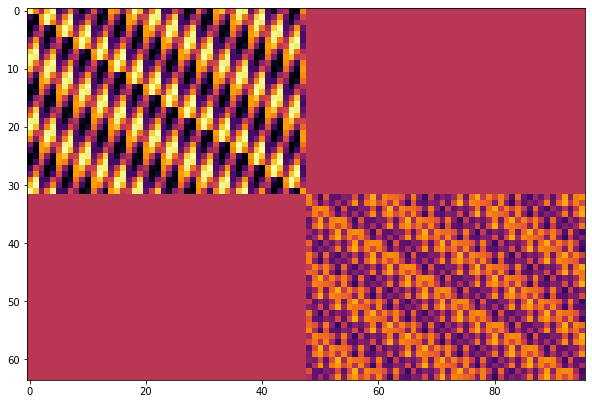

In [6]:
# Plot responce matrix (model)

plt.figure(figsize=(10, 10))
plt.imshow(responce_model.cpu().numpy(), cmap='inferno')
plt.show()

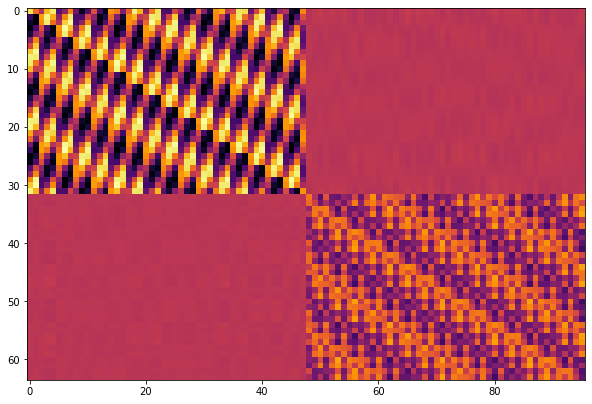

In [7]:
# Plot responce matrix (error)

plt.figure(figsize=(10, 10))
plt.imshow(responce_error.cpu().numpy(), cmap='inferno')
plt.show()

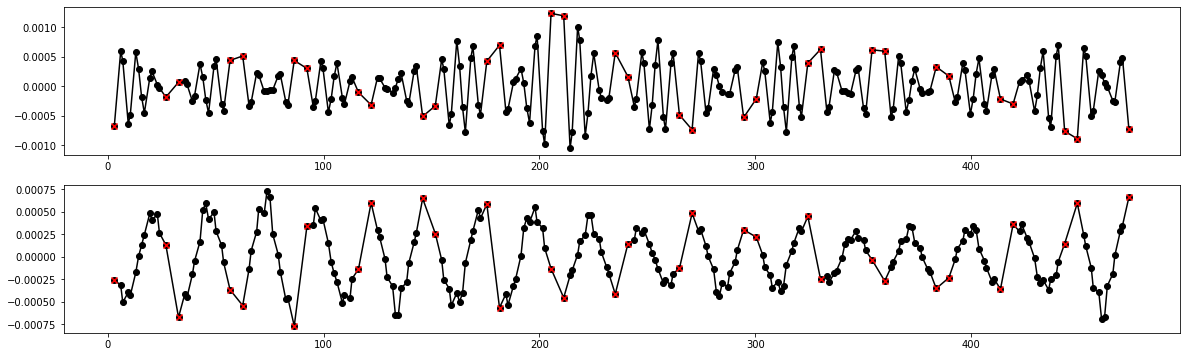

In [8]:
# Plot orbit at monitors with errors

# black -- orbit at all monitors
# red   -- orbit at ID monitors

x, _, y, _ = torch.clone(model.orbit.T)

plt.figure(figsize=(20, 2*3))

ax = plt.subplot(211)
ax.plot(model.time[model.monitor_index].cpu().numpy(), x[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x[lm].cpu().numpy(), color='red', marker='x', zorder=1)

ax = plt.subplot(212)
ax.plot(model.time[model.monitor_index].cpu().numpy(), y[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y[lm].cpu().numpy(), color='red', marker='x', zorder=1)

plt.show()

In [9]:
# Set fast correctors using model responce matrix

ax, ay = (torch.linalg.pinv(responce_model) @ torch.cat([x[lm], y[lm]])).reshape(-1, len(lc))
cx[lc] = -ax
cy[lc] = -ay

model.make_error(kn, ks, length=kl, angle_x=cx, angle_y=cy)
model.make_transport(error=True, exact=False, method='BFGS', tol=1.0E-12)

x_model, _, y_model, _ = torch.clone(model.orbit.T)

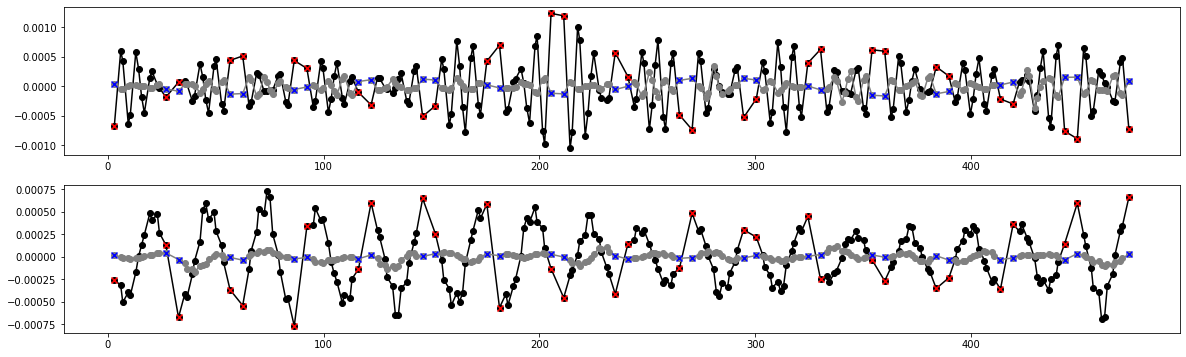

In [10]:
# Compare orbits

plt.figure(figsize=(20, 2*3))

ax = plt.subplot(211)
ax.plot(model.time[model.monitor_index].cpu().numpy(), x[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x[lm].cpu().numpy(), color='red', marker='x', zorder=1)
ax.plot(model.time[model.monitor_index].cpu().numpy(), x_model[model.monitor_index].cpu().numpy(), color='gray', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x_model[lm].cpu().numpy(), color='blue', marker='x', zorder=1)

ax = plt.subplot(212)
ax.plot(model.time[model.monitor_index].cpu().numpy(), y[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y[lm].cpu().numpy(), color='red', marker='x', zorder=1)
ax.plot(model.time[model.monitor_index].cpu().numpy(), y_model[model.monitor_index].cpu().numpy(), color='gray', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y_model[lm].cpu().numpy(), color='blue', marker='x', zorder=1)

plt.show()

In [11]:
# Set fast correctors using error responce matrix

ax, ay = (torch.linalg.pinv(responce_error) @ torch.cat([x[lm], y[lm]])).reshape(-1, len(lc))
cx[lc] = -ax
cy[lc] = -ay

model.make_error(kn, ks, length=kl, angle_x=cx, angle_y=cy)
model.make_transport(error=True, exact=False, method='BFGS', tol=1.0E-12)

x_error, _, y_error, _ = torch.clone(model.orbit.T)

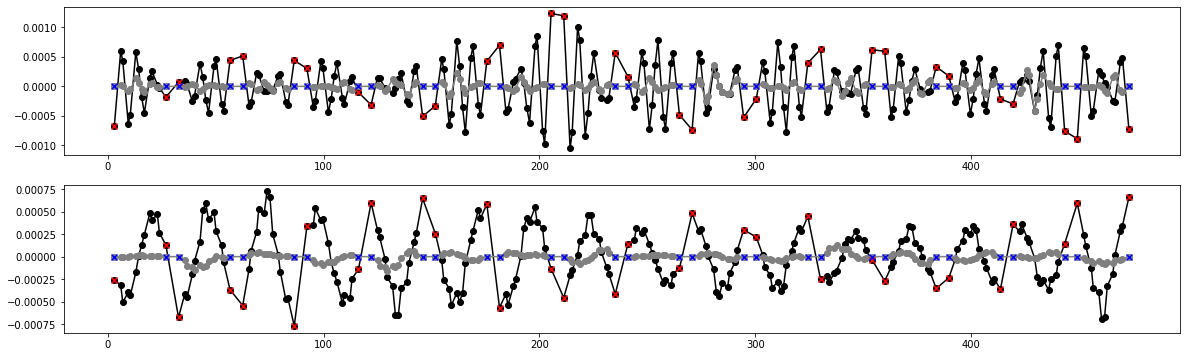

In [12]:
# Compare orbits

plt.figure(figsize=(20, 2*3))

ax = plt.subplot(211)
ax.plot(model.time[model.monitor_index].cpu().numpy(), x[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x[lm].cpu().numpy(), color='red', marker='x', zorder=1)
ax.plot(model.time[model.monitor_index].cpu().numpy(), x_error[model.monitor_index].cpu().numpy(), color='gray', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x_error[lm].cpu().numpy(), color='blue', marker='x', zorder=1)

ax = plt.subplot(212)
ax.plot(model.time[model.monitor_index].cpu().numpy(), y[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y[lm].cpu().numpy(), color='red', marker='x', zorder=1)
ax.plot(model.time[model.monitor_index].cpu().numpy(), y_error[model.monitor_index].cpu().numpy(), color='gray', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y_error[lm].cpu().numpy(), color='blue', marker='x', zorder=1)

plt.show()

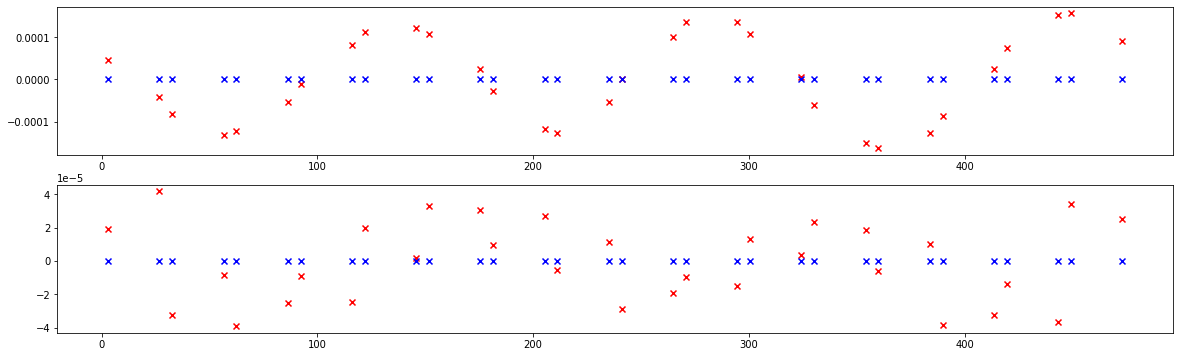

tensor(1.573627230670e-02, dtype=torch.float64)
tensor(2.828182190215e-03, dtype=torch.float64)
tensor(4.152393442146e-16, dtype=torch.float64)

tensor(1.185283454963e-02, dtype=torch.float64)
tensor(6.669207489103e-04, dtype=torch.float64)
tensor(1.169035287028e-16, dtype=torch.float64)



In [13]:
# Compare corrected orbits at ID monitors

plt.figure(figsize=(20, 2*3))

ax = plt.subplot(211)
ax.scatter(model.time[lm].cpu().numpy(), x_model[lm].cpu().numpy(), color='red', marker='x', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x_error[lm].cpu().numpy(), color='blue', marker='x', zorder=1)

ax = plt.subplot(212)
ax.scatter(model.time[lm].cpu().numpy(), y_model[lm].cpu().numpy(), color='red', marker='x', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y_error[lm].cpu().numpy(), color='blue', marker='x', zorder=1)

plt.show()

print(x[lm].abs().sum())
print(x_model[lm].abs().sum())
print(x_error[lm].abs().sum())
print()

print(y[lm].abs().sum())
print(y_model[lm].abs().sum())
print(y_error[lm].abs().sum())
print()

In [55]:
def func_obj(p):
	'''Objective function for test
	Input:
		p : a column vector
	Output:
		obj : an floating number
	'''

	obj = 0
	for ii in range(len(p)-1):
		obj -= 10*math.exp(-0.2*math.sqrt(p[ii]**2+p[ii+1]**2))

	return obj
#	obj += np.random.randn()*g_noise
	
def fuc_test0(x):
    return np.linalg.norm(x)

def test0():
    Nvar = 6
    g_vrange = np.matrix(np.ones((Nvar,2)))*150
    g_vrange[:,0] *= -1

    p0 = np.matrix(np.ones([Nvar,1]))*10.0
    x0 = np.divide(p0-g_vrange[:,0],g_vrange[:,1]-g_vrange[:,0])

    y0 = fuc_test0(x0)
    print('x0',x0)
    print('y0',y0)
    

    step = 0.01
    g_noise = 0.1
    g_cnt = 0
    g_data = np.zeros([1,Nvar+2])
    Imat = np.matrix(np.identity(Nvar))

    rcds = RCDS(func_obj, g_noise, g_cnt, Nvar, g_vrange, g_data, Imat)
    #rcds = RCDS(fuc_test0, g_noise, g_cnt, Nvar, g_vrange, g_data, Imat)
    (xm,fm,nf)=rcds.powellmain(x0,step,Imat,maxIt=10,maxEval=1000)
    print([x0,xm])
    print(y0,fm)

# test0()